# Neural machine translation with attention

## Overview 😊

The translation quality is reasonable for a toy example, but the generated attention plot is perhaps more interesting. This shows which parts of the input sentence has the model's attention while translating:

<img src="https://tensorflow.org/images/spanish-english.png" alt="spanish-english attention plot">

**Figure 1**: Example attention visualization showing how the neural machine translation model attends to different parts of the Spanish input sentence when generating each word in the English translation. The heat map demonstrates the alignment between source and target words, with brighter colors indicating stronger attention weights.

Note: This example takes approximately 10 minutes to run.


This tutorial demonstrates how to train a sequence-to-sequence (seq2seq) model for Spanish-to-English translation roughly based on [Effective Approaches to Attention-based Neural Machine Translation](https://arxiv.org/abs/1508.04025v5) (Luong et al., 2015).


This tutorial: An encoder/decoder connected by attention.


While this architecture is somewhat outdated, it is still a very useful project to work through to get a deeper understanding of sequence-to-sequence models and attention mechanisms (before going on to [Transformers](transformer.ipynb)).



This example assumes some knowledge of TensorFlow fundamentals below the level of a Keras layer:
  * [Working with tensors](https://www.tensorflow.org/guide/tensor) directly
  * [Writing custom `keras.Model`s and `keras.layers`](https://www.tensorflow.org/guide/keras/custom_layers_and_models)

After training the model in this notebook, you will be able to input a Spanish sentence, such as "*¿todavia estan en casa?*", and return the English translation: "*are you still at home?*"

The resulting model is exportable as a `tf.saved_model`, so it can be used in other TensorFlow environments.

The translation quality is reasonable for a toy example, but the generated attention plot is perhaps more interesting. This shows which parts of the input sentence has the model's attention while translating:

<figure>
  <img src="https://tensorflow.org/images/spanish-english.png" alt="spanish-english attention plot"><>
  <figcaption>Example attention plot for a translation from Spanish to English produced with neural machine translation (NMT) model.</figcaption>
</figure>

Note: This example takes approximately 10 minutes to run.

## Setup ⚙️

In [1]:
!pip install tensorflow==2.19.0 tensorflow-text matplotlib einops wrapt==1.15.0


In [2]:
# !pip install typing_extensions==4.5.0

In [3]:
!export WRAPT_DISABLE_EXTENSIONS=true

In [4]:
import numpy as np

import einops
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import tensorflow as tf
import tensorflow_text as tf_text
import wrapt
if wrapt.__version__!="1.15.0" or tf.__version__!="2.19.0":
  raise Exception(f"Please restart your session as you are still using warpt version: {wrapt.__version__}")
gpus = tf.config.list_physical_devices()
if len(gpus)>1:
  raise Exception("Please use CPUs for this notebook only. Go to Runtime at the top, then press change runtime to CPU.")

2025-10-09 17:46:51.303098: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-09 17:46:51.322711: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1760032011.345138 3306671 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1760032011.352459 3306671 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1760032011.370436 3306671 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

This tutorial uses a lot of low level API's where it's easy to get shapes wrong. This class is used to check shapes throughout the tutorial. 🧩


In [5]:
#@title
class ShapeChecker():
  """
  A utility class for checking and validating tensor shapes during model development.
  
  This class helps debug shape mismatches in neural networks by maintaining a cache
  of expected dimensions for named axes and validating that tensors conform to these
  expectations throughout the computation graph.
  
  Attributes:
      shapes (dict): A cache storing the expected dimension size for each named axis.
  
  Example:
      >>> checker = ShapeChecker()
      >>> x = tf.random.normal([32, 128, 256]) 
      >>> checker(x, 'batch seq_len hidden')  # Caches: batch=32, seq_len=128, hidden=256
      >>> y = tf.random.normal([32, 64, 256])
      >>> checker(y, 'batch new_seq hidden')  # OK: batch and hidden match cached values
  """
  
  def __init__(self):
    """
    Initialize the ShapeChecker with an empty cache.
    
    The cache will be populated as tensors are checked, storing the dimension
    size for each named axis encountered.
    """
    # Keep a cache of every axis-name seen
    self.shapes = {}

  def __call__(self, tensor, names, broadcast=False):
    """
    Check that a tensor's shape matches previously seen dimensions for named axes.
    
    Args:
        tensor (tf.Tensor): The tensor whose shape should be validated.
        names (str): A space-separated string of axis names corresponding to 
                    tensor dimensions. Example: 'batch seq_len hidden'
        broadcast (bool, optional): If True, allows dimensions of size 1 to 
                                  bypass validation. Defaults to False.
    
    Raises:
        ValueError: If a dimension size doesn't match the previously cached
                   size for the same axis name.
    
    Returns:
        None: This method performs validation but doesn't return values.
    
    Example:
        >>> checker = ShapeChecker()
        >>> x = tf.constant([[1, 2, 3], [4, 5, 6]])  # Shape: (2, 3)
        >>> checker(x, 'batch features')  # Caches batch=2, features=3
        >>> y = tf.constant([[7, 8, 9]])  # Shape: (1, 3)
        >>> checker(y, 'new_batch features')  # OK: features=3 matches cache; new_batch=1 is not cached
    """
    # Only check shapes when running eagerly (not in graph mode) 
    # running eagerly means that operations are executed immediately
    # this is in contrast to graph mode, where operations are built 
    # into a computational graph that is executed
    if not tf.executing_eagerly():
      return

    # einops is a Python library for flexible and readable tensor operations.
    # It provides functions to parse, reshape, and manipulate tensor shapes using simple string-based notation.
    # Here, einops.parse_shape is used to extract the dimensions of the tensor according to the provided axis names.
    parsed = einops.parse_shape(tensor, names)

    # Check each axis name and its dimension
    for name, new_dim in parsed.items():
      old_dim = self.shapes.get(name, None)

      # If broadcasting is allowed and the new dimension is 1, skip the check
      if (broadcast and new_dim == 1):
        continue

      if old_dim is None:
        # If the axis name is new, add its length to the cache.
        self.shapes[name] = new_dim
        continue

      # If the dimension has changed, raise an error
      if new_dim != old_dim:
        raise ValueError(f"Shape mismatch for dimension: '{name}'\n"
                         f"    found: {new_dim}\n"
                         f"    expected: {old_dim}\n")

## Data Preparation 🗂️

The tutorial uses a language dataset provided by [Anki](http://www.manythings.org/anki/). This dataset contains language translation pairs in the format:

```
May I borrow this book?	¿Puedo tomar prestado este libro?
```

They have a variety of languages available, but this example uses the English-Spanish dataset.

### Download and prepare the dataset 📥🗂️

For convenience, a copy of this dataset is hosted on Google Cloud, but you can also download your own copy. After downloading the dataset, here are the steps you need to take to prepare the data:

1. Add a *start* and *end* token to each sentence. 🚩🏁
2. Clean the sentences by removing special characters. 🧹
3. Create a word index and reverse word index (dictionaries mapping from word → id and id → word). 🔢🔄
4. Pad each sentence to a maximum length. 📏

In [6]:
# Download the Spanish-English translation dataset as a zip file.
import pathlib

# Use TensorFlow utility to download and extract the dataset.
path_to_zip = tf.keras.utils.get_file(
    'spa-eng.zip',  # Name of the file to download.
    origin='http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip',  # URL of the dataset.
    extract=True  # Automatically extract the zip file after downloading.
)

# Construct the path to the extracted text file containing sentence pairs.
path_to_file = pathlib.Path(path_to_zip).parent/'spa-eng_extracted/spa-eng/spa.txt'

In [7]:
# show a list of file contents
!ls -l $path_to_file

-rw-rw-r-- 1 zkhechadoorian zkhechadoorian 8042772 Oct  9 17:46 /home/zkhechadoorian/.keras/datasets/spa-eng_extracted/spa-eng/spa.txt


To take a look of the data, we will call the cat command and display the first 20 lines.

In [8]:
!cat {path_to_file} | head -n 20

Go.	Ve.
Go.	Vete.
Go.	Vaya.
Go.	Váyase.
Hi.	Hola.
Run!	¡Corre!
Run.	Corred.
Who?	¿Quién?
Fire!	¡Fuego!
Fire!	¡Incendio!
Fire!	¡Disparad!
Help!	¡Ayuda!
Help!	¡Socorro! ¡Auxilio!
Help!	¡Auxilio!
Jump!	¡Salta!
Jump.	Salte.
Stop!	¡Parad!
Stop!	¡Para!
Stop!	¡Pare!
Wait!	¡Espera!
cat: write error: Broken pipe


In [9]:
context_raw = open(path_to_file, 'r', encoding='utf-8').read().split('\n') # read the file and split into lines
context_raw[0:10]

['Go.\tVe.',
 'Go.\tVete.',
 'Go.\tVaya.',
 'Go.\tVáyase.',
 'Hi.\tHola.',
 'Run!\t¡Corre!',
 'Run.\tCorred.',
 'Who?\t¿Quién?',
 'Fire!\t¡Fuego!',
 'Fire!\t¡Incendio!']

In [10]:
# find lines that do not have exactly two tab-separated parts
invalid_lines = [line for line in context_raw if len(line.split('\t')) != 2]
print(f"Number of invalid lines: {len(invalid_lines)}")
print(f"Some invalid lines: {invalid_lines[:5]}")

Number of invalid lines: 1
Some invalid lines: ['']


In [11]:
# remove invalid lines
context_raw = [line for line in context_raw if len(line.split('\t')) == 2]

In [12]:
# vector of spanish phrases
spanish_phrases = [line.split('\t')[1] for line in context_raw]
# vector of english phrases
english_phrases = [line.split('\t')[0] for line in context_raw]

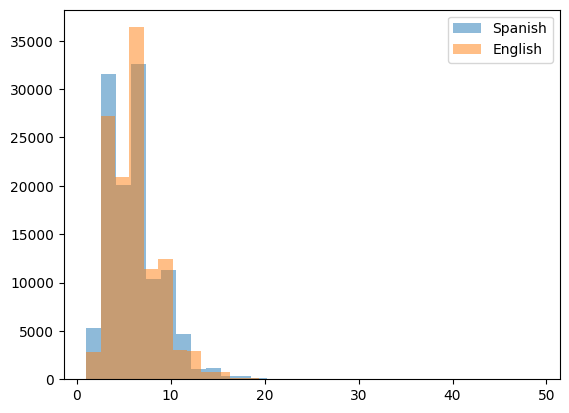

In [13]:
# distribution of word count 
spanish_word_counts = [len(phrase.split()) for phrase in spanish_phrases]
english_word_counts = [len(phrase.split()) for phrase in english_phrases]
plt.hist(spanish_word_counts, bins=30, alpha=0.5, label='Spanish')
plt.hist(english_word_counts, bins=30, alpha=0.5, label='English')
plt.legend()
plt.savefig("assets/word_count_distribution.png")


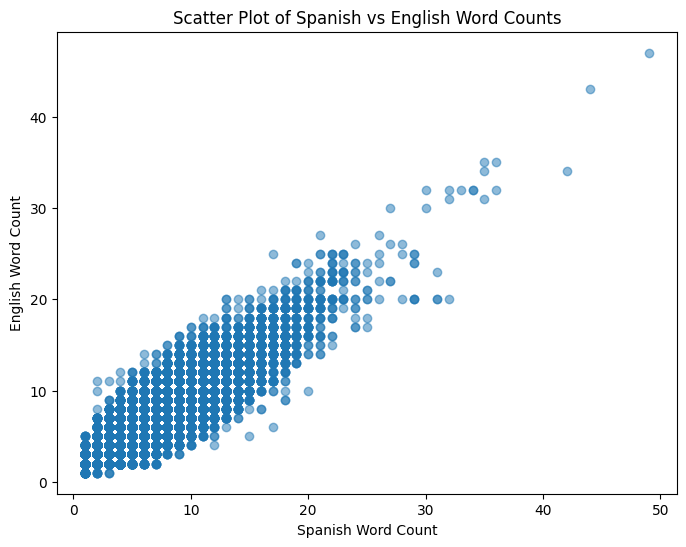

In [14]:
# scatter plot of word counts
plt.figure(figsize=(8, 6))
plt.scatter(spanish_word_counts, english_word_counts, alpha=0.5)
plt.xlabel('Spanish Word Count')
plt.ylabel('English Word Count')
plt.title('Scatter Plot of Spanish vs English Word Counts')
plt.savefig("assets/word_count_scatter.png")

In [15]:
# Find interesting translation patterns
def find_patterns():
    patterns = {
        'questions': [],
        'exclamations': [],
        'short_sentences': [],
        'long_sentences': [],
        'formal_informal': []
    }
    
    for sp, en in zip(spanish_phrases[:1000], english_phrases[:1000]):
        if sp.startswith('¿') and sp.endswith('?') or '?' in en:
            patterns['questions'].append((sp, en))
        if '!' in sp or en:
            patterns['exclamations'].append((sp, en))
        if len(sp.split()) <= 3:
            patterns['short_sentences'].append((sp, en))
        if len(sp.split()) >= 15:
            patterns['long_sentences'].append((sp, en))
        if any(word in sp.lower() for word in ['usted', 'señor', 'señora']):
            patterns['formal_informal'].append((sp, en))
    
    return patterns

patterns = find_patterns()
print(f"Questions found: {len(patterns['questions'])}")
print("Sample questions:\n\n")
for sp, en in patterns['questions'][:3]:
    print(f"SP: {sp}")
    print(f"EN: {en}\n")

Questions found: 65
Sample questions:


SP: ¿Quién?
EN: Who?

SP: ¿Lo pillas?
EN: Got it?

SP: ¿Entendiste?
EN: Got it?



In [16]:
def load_data(path: pathlib.Path):
  """
  Load and parse a Spanish-English translation dataset from a text file.
  
  This function reads a tab-separated text file containing translation pairs and
  splits them into separate arrays for target (English) and context (Spanish) sentences.
  Each line in the file should contain an English sentence and its Spanish translation
  separated by a tab character.
  
  Args:
      path (pathlib.Path): Path to the text file containing translation pairs.
                          Expected format: "English sentence\\tSpanish sentence\\n"
  
  Returns:
      tuple[np.ndarray, np.ndarray]: A tuple containing:
          - target (np.ndarray): Array of English sentences (translation targets)
          - context (np.ndarray): Array of Spanish sentences (source context)
  
  Example:
      >>> path = pathlib.Path("spa-eng.txt")
      >>> english_sentences, spanish_sentences = load_data(path)
      >>> print(english_sentences[0])  # "Hello."
      >>> print(spanish_sentences[0])  # "Hola."
  
  Note:
      - File must be UTF-8 encoded
      - Each line should contain exactly one tab character separating the pair
      - Empty lines will result in incomplete pairs and may cause errors
      - The function assumes the format: English\\tSpanish (target\\tcontext)
  
  Raises:
      FileNotFoundError: If the specified file path doesn't exist
      UnicodeDecodeError: If the file is not properly UTF-8 encoded
      ValueError: If lines don't contain the expected tab-separated format
  """
  # Read the entire text file as a string using UTF-8 encoding
  text = path.read_text(encoding='utf-8')

  # Split the text into lines
  lines = text.splitlines()
  # Split each line into a pair (target, context) using tab as the separator
  pairs = [line.split('\t') for line in lines]

  # Extract the context sentences (Spanish) from each pair
  context = np.array([context for target, context in pairs])
  # Extract the target sentences (English) from each pair
  target = np.array([target for target, context in pairs])

  # Return the target and context arrays
  return target, context

In [17]:
# Load the data from the specified file path.
# The load_data function reads the file, splits each line into English (target) and Spanish (context) sentence pairs,
# and returns them as numpy arrays.
target_raw, context_raw = load_data(path_to_file)

print(context_raw[-1])

Si quieres sonar como un hablante nativo, debes estar dispuesto a practicar diciendo la misma frase una y otra vez de la misma manera en que un músico de banjo practica el mismo fraseo una y otra vez hasta que lo puedan tocar correctamente y en el tiempo esperado.


In [18]:
print(target_raw[-1])

If you want to sound like a native speaker, you must be willing to practice saying the same sentence over and over in the same way that banjo players practice the same phrase over and over until they can play it correctly and at the desired tempo.


### Create a tf.data dataset 📦

From these arrays of strings you can create a `tf.data.Dataset` of strings that shuffles and batches them efficiently: 🎲📦

In [19]:
# Set the buffer size for shuffling to the total number of context sentences
BUFFER_SIZE = len(context_raw)
# Set the batch size for training and validation
BATCH_SIZE = 64

# Randomly assign each example to the training set (80%) or validation set (20%)
is_train = np.random.uniform(size=(len(target_raw),)) < 0.8

# Create the training dataset:
# - Select context and target sentences assigned to training
# - Shuffle the dataset
# - Batch the dataset
train_raw = (
    tf.data.Dataset
    .from_tensor_slices((context_raw[is_train], target_raw[is_train]))
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE))

# Create the validation dataset:
# - Select context and target sentences not assigned to training
# - Shuffle the dataset
# - Batch the dataset
val_raw = (
    tf.data.Dataset
    .from_tensor_slices((context_raw[~is_train], target_raw[~is_train]))
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE))

In [20]:
# Iterate over one batch from the training dataset
for example_context_strings, example_target_strings in train_raw.take(1):
  # Print the first 5 context (Spanish) sentences in the batch
  print(example_context_strings[:5])
  print()
  # Print the first 5 target (English) sentences in the batch
  print(example_target_strings[:5])
  break  # Exit after processing the first batch

tf.Tensor(
[b'Pas\xc3\xa9 mucho tiempo ocup\xc3\xa1ndome de ese problema la semana pasada.'
 b'No hagas preguntas.' b'Desistamos.'
 b'\xc2\xbfQu\xc3\xa9 har\xc3\xadas si hoy fuese tu \xc3\xbaltimo d\xc3\xada?'
 b'Busqu\xc3\xa9 algo para ponerme en mi armario, pero no pude encontrar nada apropiado para la ocasi\xc3\xb3n.'], shape=(5,), dtype=string)

tf.Tensor(
[b'I spent a great deal of time dealing with that problem last week.'
 b"Don't ask questions." b"Let's quit."
 b'What would you do if this was your last day?'
 b"I looked in my closet for something to wear, but couldn't find anything appropriate for the occasion."], shape=(5,), dtype=string)


### Text preprocessing

One of the goals of this tutorial is to build a model that can be exported as a `tf.saved_model`. To make that exported model useful it should take `tf.string` inputs, and return `tf.string` outputs: All the text processing happens inside the model. Mainly using a `layers.TextVectorization` layer. 🏗️🔤✨

#### Standardization

The model is dealing with multilingual text with a limited vocabulary. So it will be important to standardize the input text. 🌐🔤

The first step is Unicode normalization to split accented characters and replace compatibility characters with their ASCII equivalents. 🧹

The `tensorflow_text` package contains a unicode normalize operation:

In [21]:
# Define a sample Spanish sentence as a TensorFlow constant
example_text = tf.constant('¿Todavía está en casa?')

# Print the raw bytes of the example text
print(example_text.numpy())

# Normalize the example text using Unicode normalization (NFKD form)
# This splits accented characters and replaces compatibility characters with their ASCII equivalents
print(tf_text.normalize_utf8(example_text, 'NFKD').numpy())

b'\xc2\xbfTodav\xc3\xada est\xc3\xa1 en casa?'
b'\xc2\xbfTodavi\xcc\x81a esta\xcc\x81 en casa?'


Unicode normalization will be the first step in the text standardization function:

In [22]:
def tf_lower_and_split_punct(text):
  # Unicode normalization (NFKD) splits accented characters into base + accent,
  # and replaces compatibility characters with their canonical equivalents.
  # This helps standardize multilingual text for processing.
  text = tf_text.normalize_utf8(text, 'NFKD')

  # Convert all characters to lowercase for consistency.
  text = tf.strings.lower(text)

  # Remove all characters except spaces, lowercase letters, and select punctuation.
  text = tf.strings.regex_replace(text, '[^ a-z.?!,¿]', '')

  # Add spaces around punctuation marks to separate them from words.
  text = tf.strings.regex_replace(text, '[.?!,¿]', r' \0 ')

  # Remove leading and trailing whitespace.
  text = tf.strings.strip(text)

  # Add [START] and [END] tokens to mark the beginning and end of the sentence.
  # These tokens help the model know where a sentence starts and ends,
  # which is important for sequence-to-sequence tasks like translation.
  text = tf.strings.join(['[START]', text, '[END]'], separator=' ')
  return text

In [23]:
# Print the original example text as a string
print(example_text.numpy().decode())

# Print the example text after applying the text preprocessing function
# This function normalizes, lowercases, removes unwanted characters,
# adds spaces around punctuation, strips whitespace, and adds [START] and [END] tokens
print(tf_lower_and_split_punct(example_text).numpy().decode())

¿Todavía está en casa?
[START] ¿ todavia esta en casa ? [END]


#### Text Vectorization

This standardization function will be wrapped up in a `tf.keras.layers.TextVectorization` layer which will handle the vocabulary extraction and conversion of input text to sequences of tokens.

In [24]:
# Set the maximum vocabulary size for the text vectorization layer
max_vocab_size = 6000 # Limit on the number of unique tokens in the vocabulary

# Create a TextVectorization layer for processing Spanish context sentences.
# - standardize: applies the tf_lower_and_split_punct function to clean and tokenize the text
# - max_tokens: limits the vocabulary size to max_vocab_size
# - ragged: allows variable-length outputs for tokenized sentences, which is useful for handling sentences of different lengths
context_text_processor = tf.keras.layers.TextVectorization(
    standardize=tf_lower_and_split_punct,
    max_tokens=max_vocab_size,
    ragged=True)

The `TextVectorization` layer and many other [Keras preprocessing layers](https://www.tensorflow.org/guide/keras/preprocessing_layers) have an `adapt` method. This method reads one epoch of the training data, and works a lot like `Model.fit`. This `adapt` method initializes the layer based on the data. Here it determines the vocabulary: 🧠🔤

In [25]:
# Adapt the context_text_processor to the training data.
# This step analyzes the context (Spanish) sentences in train_raw,
# builds the vocabulary, and prepares the text vectorization layer.
context_text_processor.adapt(train_raw.map(lambda context, target: context))

# Display the first 10 words from the vocabulary learned by the context_text_processor.
context_text_processor.get_vocabulary()[:10]

2025-10-09 17:47:03.438285: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


['',
 '[UNK]',
 np.str_('[START]'),
 np.str_('[END]'),
 np.str_('.'),
 np.str_('que'),
 np.str_('de'),
 np.str_('el'),
 np.str_('a'),
 np.str_('no')]

# Exploration of Tokenized Context Vectors

Vocabulary size: 6000
First 20 tokens: ['', '[UNK]', np.str_('[START]'), np.str_('[END]'), np.str_('.'), np.str_('que'), np.str_('de'), np.str_('el'), np.str_('a'), np.str_('no'), np.str_('tom'), np.str_('la'), np.str_('?'), np.str_('¿'), np.str_('en'), np.str_('es'), np.str_('un'), np.str_('se'), np.str_('me'), np.str_(',')]
Last 20 tokens: [np.str_('persiguio'), np.str_('perra'), np.str_('perfume'), np.str_('perdono'), np.str_('perdoneme'), np.str_('perdonarle'), np.str_('perdidos'), np.str_('perderte'), np.str_('perdemos'), np.str_('perdedor'), np.str_('pensabamos'), np.str_('peluquero'), np.str_('pelean'), np.str_('pelar'), np.str_('pegarle'), np.str_('pegar'), np.str_('pegada'), np.str_('pega'), np.str_('patinaje'), np.str_('patada')]


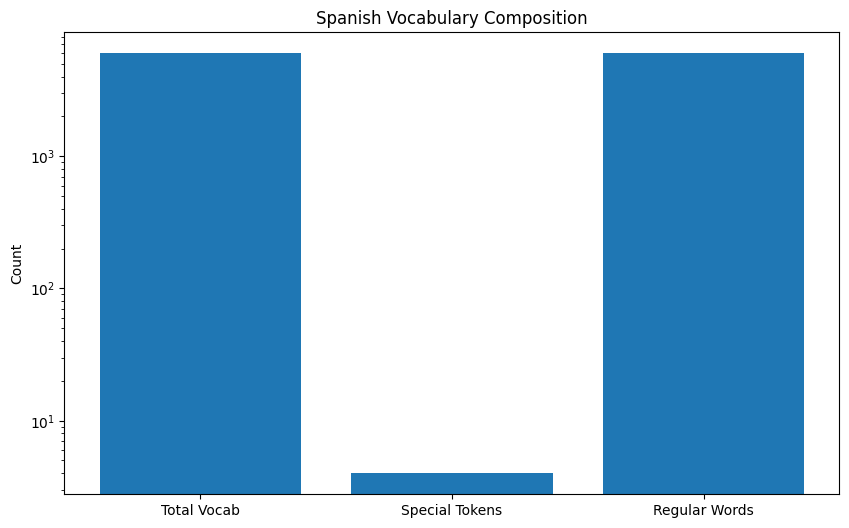

<Figure size 640x480 with 0 Axes>

In [26]:
# Get vocabulary information
vocab = context_text_processor.get_vocabulary()
vocab_size = len(vocab)

print(f"Vocabulary size: {vocab_size}")
print(f"First 20 tokens: {vocab[:20]}")
print(f"Last 20 tokens: {vocab[-20:]}")

# Visualize vocabulary size on a log scale
plt.figure(figsize=(10, 6))
plt.yscale('log')
plt.bar(['Total Vocab', 'Special Tokens', 'Regular Words'], 
        [vocab_size, 4, vocab_size-4])  # Assuming 4 special tokens
plt.title('Spanish Vocabulary Composition')
plt.ylabel('Count')
plt.show()
plt.savefig("assets/spanish_vocab_composition.png")

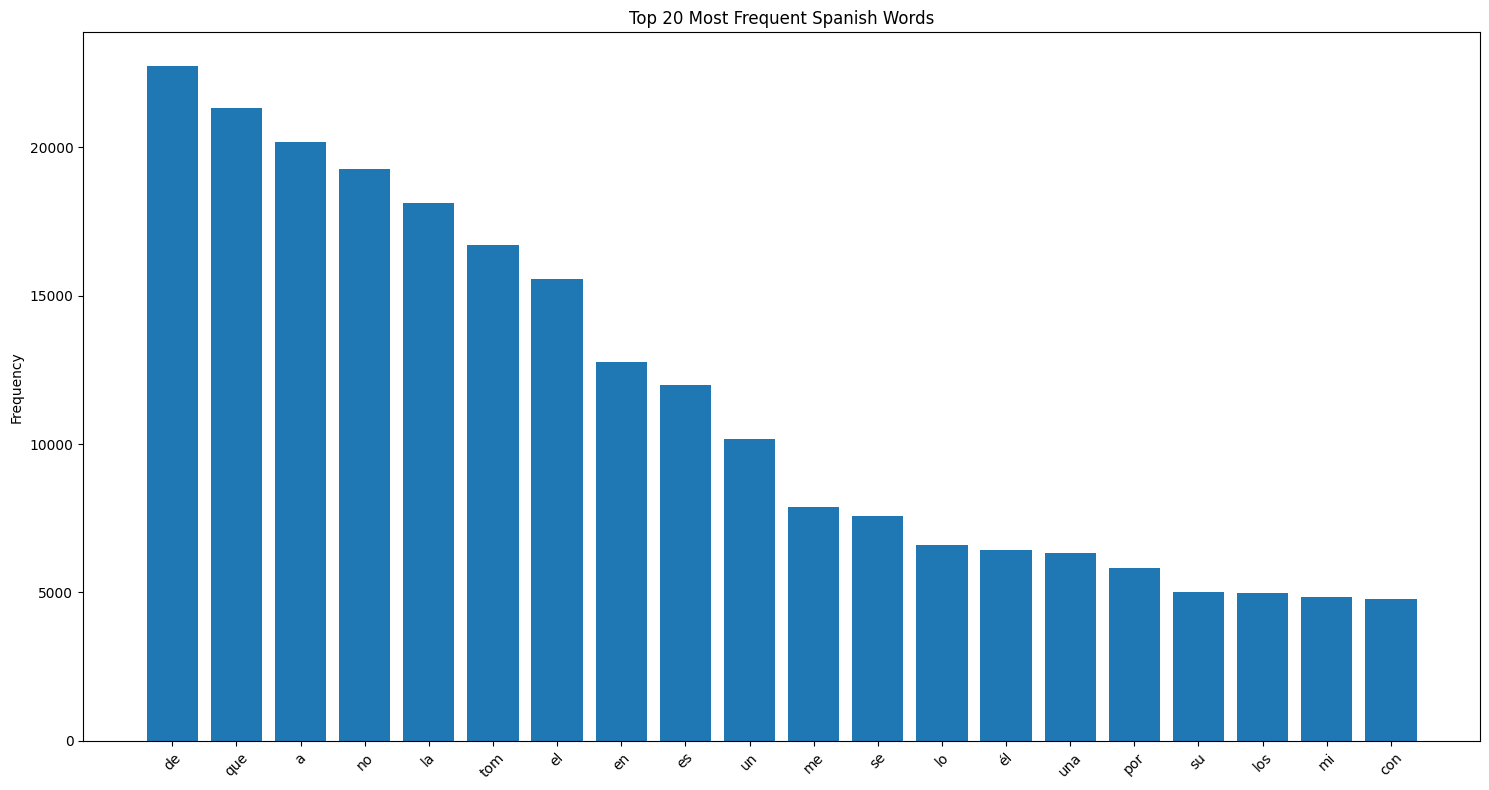

<Figure size 640x480 with 0 Axes>

In [27]:
# Get word frequencies (if available)
import collections

# Extract all Spanish words from your data
all_spanish_text = ' '.join(context_raw)
word_freq = collections.Counter(all_spanish_text.lower().split())

# Plot top words
top_words = dict(word_freq.most_common(20))
plt.figure(figsize=(15, 8))
plt.bar(range(len(top_words)), list(top_words.values()))
plt.xticks(range(len(top_words)), list(top_words.keys()), rotation=45)
plt.title('Top 20 Most Frequent Spanish Words')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()
plt.savefig("assets/top_spanish_words.png")

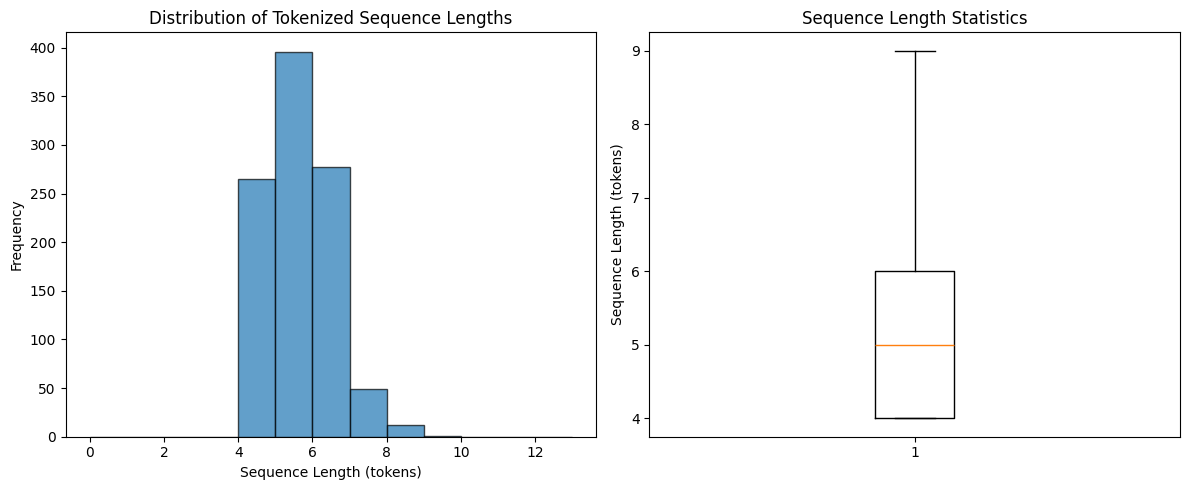

Mean sequence length: 5.15
Max sequence length: 9
Min sequence length: 4


<Figure size 640x480 with 0 Axes>

In [28]:
# Analyze tokenized sequences
sample_spanish = context_raw[:1000]  # Sample for analysis
tokenized = context_text_processor(sample_spanish)

# Get sequence lengths
seq_lengths = [tf.reduce_sum(tf.cast(seq != 0, tf.int32)).numpy() for seq in tokenized]

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(seq_lengths, bins=range(0,14), edgecolor='black', alpha=0.7)
plt.xlabel('Sequence Length (tokens)')
plt.ylabel('Frequency')
plt.title('Distribution of Tokenized Sequence Lengths')

plt.subplot(1, 2, 2)
plt.boxplot(seq_lengths)
plt.ylabel('Sequence Length (tokens)')
plt.title('Sequence Length Statistics')

plt.tight_layout()
plt.show()

print(f"Mean sequence length: {np.mean(seq_lengths):.2f}")
print(f"Max sequence length: {max(seq_lengths)}")
print(f"Min sequence length: {min(seq_lengths)}")

plt.savefig("assets/sequence_length_distribution.png")

In [29]:
# Show tokenization examples
def show_tokenization_examples(processor, texts, n=5):
    """Show how text gets tokenized"""
    print("=== TOKENIZATION EXAMPLES ===\n")
    
    for i, text in enumerate(texts[:n]):
        # Tokenize
        tokens = processor([text])
        token_ids = tokens[0].numpy()
        
        # Convert back to words
        vocab = processor.get_vocabulary()
        words = [vocab[token_id] for token_id in token_ids if token_id != 0]
        
        print(f"Example {i+1}:")
        print(f"Original: {text}")
        print(f"Tokens:   {token_ids[:15]}...")  # Show first 15 tokens
        print(f"Words:    {words[:15]}")
        print(f"Length:   {len([t for t in token_ids if t != 0])} tokens")
        print("-" * 50)

show_tokenization_examples(context_text_processor, context_raw)

=== TOKENIZATION EXAMPLES ===

Example 1:
Original: Ve.
Tokens:   [  2 375   4   3]...
Words:    [np.str_('[START]'), np.str_('ve'), np.str_('.'), np.str_('[END]')]
Length:   4 tokens
--------------------------------------------------
Example 2:
Original: Vete.
Tokens:   [   2 1327    4    3]...
Words:    [np.str_('[START]'), np.str_('vete'), np.str_('.'), np.str_('[END]')]
Length:   4 tokens
--------------------------------------------------
Example 3:
Original: Vaya.
Tokens:   [  2 523   4   3]...
Words:    [np.str_('[START]'), np.str_('vaya'), np.str_('.'), np.str_('[END]')]
Length:   4 tokens
--------------------------------------------------
Example 4:
Original: Váyase.
Tokens:   [   2 5787    4    3]...
Words:    [np.str_('[START]'), np.str_('vayase'), np.str_('.'), np.str_('[END]')]
Length:   4 tokens
--------------------------------------------------
Example 5:
Original: Hola.
Tokens:   [   2 2042    4    3]...
Words:    [np.str_('[START]'), np.str_('hola'), np.str_('.'), np.st

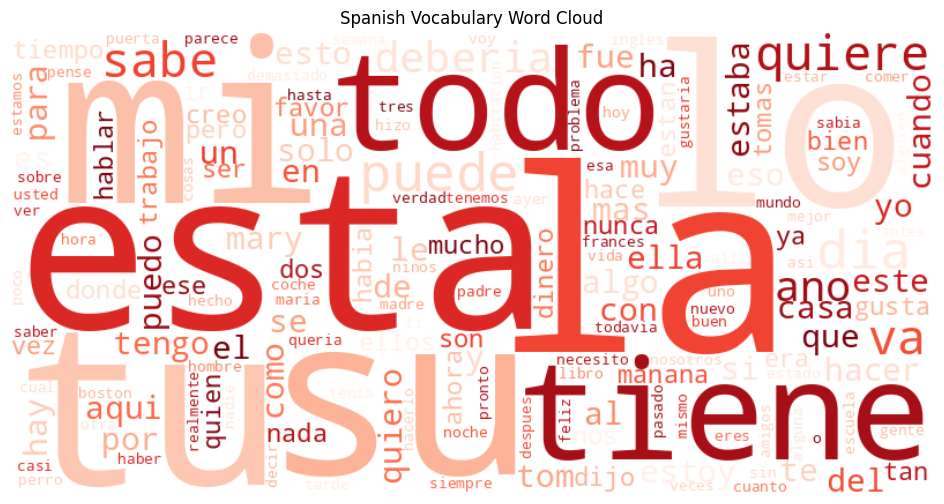

<Figure size 640x480 with 0 Axes>

In [30]:
from wordcloud import WordCloud

# Create word cloud from vocabulary
vocab_text = ' '.join(vocab[4:200])  # Skip special tokens, use top words

wordcloud = WordCloud(width=800, height=400, 
                     background_color='white',
                     colormap='Reds').generate(vocab_text)

plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Spanish Vocabulary Word Cloud')
plt.show()
plt.savefig("assets/spanish_vocab_wordcloud.png")

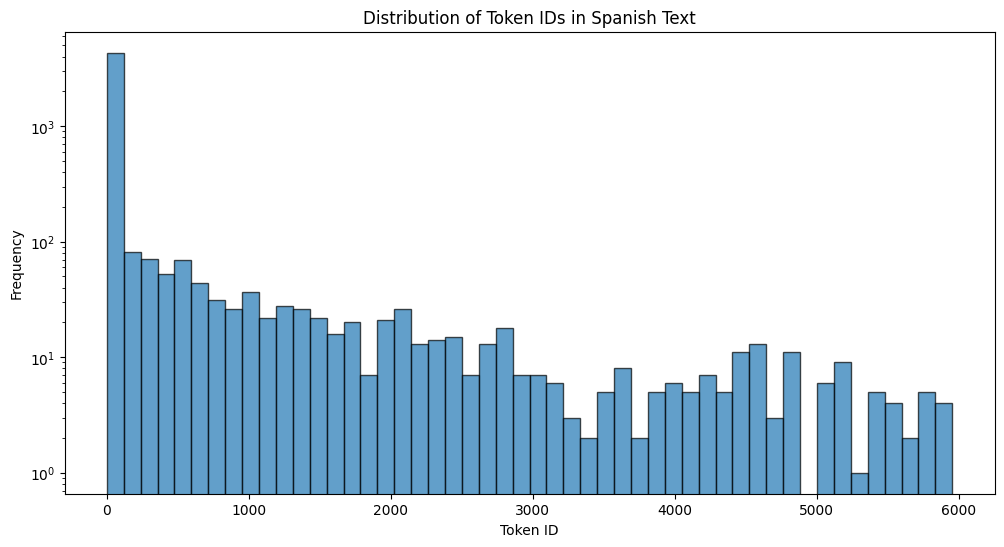

Most used tokens:
Token 2 ('[START]'): 1000 times
Token 3 ('[END]'): 1000 times
Token 4 ('.'): 802 times
Token 1 ('[UNK]'): 315 times
Token 85 ('!'): 137 times
Token 8 ('a'): 86 times
Token 10 ('tom'): 73 times
Token 13 ('¿'): 65 times
Token 12 ('?'): 65 times
Token 41 ('estoy'): 53 times


<Figure size 640x480 with 0 Axes>

In [31]:
# Analyze token ID usage
sample_tokens = context_text_processor(context_raw[:1000])
flat_tokens = tf.reshape(sample_tokens, [-1])
non_zero_tokens = flat_tokens[flat_tokens != 0]

plt.figure(figsize=(12, 6))
plt.hist(non_zero_tokens.numpy(), bins=50, edgecolor='black', alpha=0.7)
plt.xlabel('Token ID')
plt.ylabel('Frequency')
# log scale for better visibility
plt.yscale('log')
plt.title('Distribution of Token IDs in Spanish Text')
plt.show()

# Most and least used tokens
token_counts = collections.Counter(non_zero_tokens.numpy())
print("Most used tokens:")
for token_id, count in token_counts.most_common(10):
    print(f"Token {token_id} ('{vocab[token_id]}'): {count} times")

plt.savefig("assets/token_id_distribution.png")

In [32]:
def analyze_sentence(processor, sentence):
    """Comprehensive analysis of a single sentence"""
    print(f"=== ANALYZING: '{sentence}' ===")
    
    # Preprocess
    processed = tf_lower_and_split_punct(tf.constant(sentence)).numpy().decode()
    print(f"Preprocessed: {processed}")
    
    # Tokenize
    tokens = processor([processed])
    token_ids = tokens[0].numpy()
    
    # Get vocabulary
    vocab = processor.get_vocabulary()
    
    # Show token mapping
    print("\nToken mapping:")
    for i, token_id in enumerate(token_ids):
        if token_id != 0:  # Skip padding
            word = vocab[token_id]
            print(f"  {i:2d}: {token_id:4d} -> '{word}'")
    
    print(f"\nStatistics:")
    print(f"  Original words: {len(sentence.split())}")
    print(f"  Processed words: {len(processed.split())}")
    print(f"  Token count: {len([t for t in token_ids if t != 0])}")

# Try it
analyze_sentence(context_text_processor, "¿Cómo estás hoy?")

=== ANALYZING: '¿Cómo estás hoy?' ===
Preprocessed: [START] ¿ como estas hoy ? [END]

Token mapping:
   0:    2 -> '[START]'
   1:    1 -> '[UNK]'
   2:   13 -> '¿'
   3:   38 -> 'como'
   4:   77 -> 'estas'
   5:  108 -> 'hoy'
   6:   12 -> '?'
   7:    1 -> '[UNK]'
   8:    3 -> '[END]'

Statistics:
  Original words: 3
  Processed words: 7
  Token count: 9


In [33]:
# print 3 examples containing token '[UNK]'
print("=== EXAMPLES WITH [UNK] TOKEN ===\n")
unk_token_id = context_text_processor.get_vocabulary().index('[UNK]')
count = 0
for text in context_raw:
    tokens = context_text_processor([text])
    token_ids = tokens[0].numpy()
    if unk_token_id in token_ids:
        print(f"Original: {text}\t\t Translation: {target_raw[np.where(context_raw==text)[0][0]]}")
        #print(f"Tokens:   {token_ids[:15]}...")  # Show first 15 tokens
        vocab = context_text_processor.get_vocabulary()
        words = [vocab[token_id] for token_id in token_ids if token_id != 0]
        print(f"Words:    {words[:15]}")
        #print(f"Length:   {len([t for t in token_ids if t != 0])} tokens")
        #print("-" * 50)
        count += 1
    if count >= 10:
        break

=== EXAMPLES WITH [UNK] TOKEN ===

Original: Corred.		 Translation: Run.
Words:    [np.str_('[START]'), '[UNK]', np.str_('.'), np.str_('[END]')]
Original: ¡Disparad!		 Translation: Fire!
Words:    [np.str_('[START]'), '[UNK]', np.str_('!'), np.str_('[END]')]
Original: ¡Socorro! ¡Auxilio!		 Translation: Help!
Words:    [np.str_('[START]'), '[UNK]', np.str_('!'), '[UNK]', np.str_('!'), np.str_('[END]')]
Original: ¡Auxilio!		 Translation: Help!
Words:    [np.str_('[START]'), '[UNK]', np.str_('!'), np.str_('[END]')]
Original: ¡Salta!		 Translation: Jump!
Words:    [np.str_('[START]'), '[UNK]', np.str_('!'), np.str_('[END]')]
Original: Salte.		 Translation: Jump.
Words:    [np.str_('[START]'), '[UNK]', np.str_('.'), np.str_('[END]')]
Original: ¡Parad!		 Translation: Stop!
Words:    [np.str_('[START]'), '[UNK]', np.str_('!'), np.str_('[END]')]
Original: Tomátelo con soda.		 Translation: Relax.
Words:    [np.str_('[START]'), '[UNK]', np.str_('con'), '[UNK]', np.str_('.'), np.str_('[END]')]
Or

### Meaning of [UNK]

UNK is used for unknown words. These words may not appear commonly enough in the training data. 

In [34]:
def analyze_unk_patterns(processor, texts):
    """Analyze what causes [UNK] tokens"""
    vocab = processor.get_vocabulary()
    unk_id = vocab.index('[UNK]') if '[UNK]' in vocab else None
    
    if unk_id is None:
        print("No [UNK] token found in vocabulary")
        return
    
    unk_count = 0
    total_tokens = 0
    
    for text in texts[:1000]:  # Sample
        tokens = processor([text])
        token_array = tokens[0].numpy()
        
        unk_count += sum(1 for t in token_array if t == unk_id)
        total_tokens += sum(1 for t in token_array if t != 0)  # Non-padding
    
    unk_percentage = (unk_count / total_tokens) * 100 if total_tokens > 0 else 0
    
    print(f"[UNK] Statistics:")
    print(f"  Total [UNK] tokens: {unk_count}")
    print(f"  Total tokens: {total_tokens}")
    print(f"  [UNK] percentage: {unk_percentage:.2f}%")

analyze_unk_patterns(context_text_processor, context_raw)

[UNK] Statistics:
  Total [UNK] tokens: 315
  Total tokens: 5150
  [UNK] percentage: 6.12%


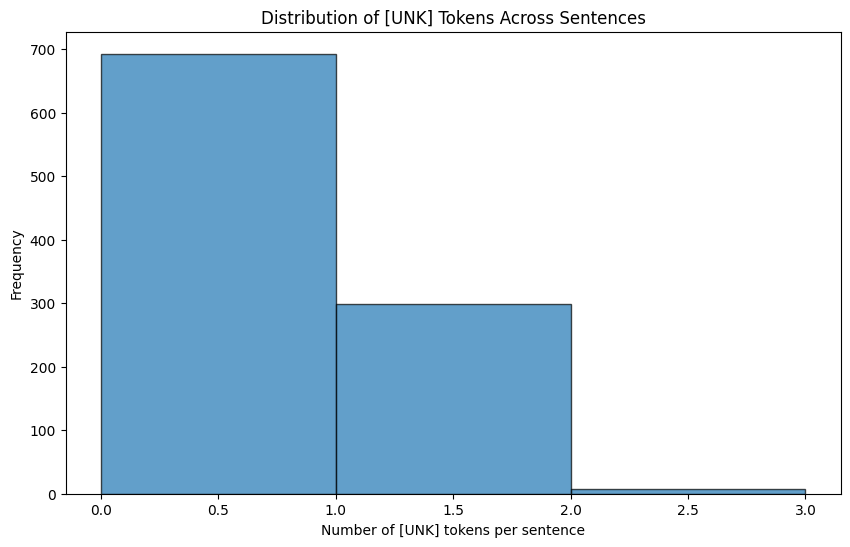

Sentences with [UNK]: 307
Max [UNK] in one sentence: 2


<Figure size 640x480 with 0 Axes>

In [35]:
def visualize_unk_distribution(processor, texts, filename):
    """Visualize [UNK] token distribution"""
    vocab = processor.get_vocabulary()
    unk_id = vocab.index('[UNK]') if '[UNK]' in vocab else None
    
    if unk_id is None:
        print("No [UNK] token in vocabulary")
        return
    
    unk_per_sentence = []
    
    for text in texts[:1000]:
        tokens = processor([text])
        token_array = tokens[0].numpy()
        unk_count = sum(1 for t in token_array if t == unk_id)
        unk_per_sentence.append(unk_count)
    
    plt.figure(figsize=(10, 6))
    plt.hist(unk_per_sentence, bins=range(0,4), edgecolor='black', alpha=0.7)
    plt.xlabel('Number of [UNK] tokens per sentence')
    plt.ylabel('Frequency')
    plt.title('Distribution of [UNK] Tokens Across Sentences')
    plt.show()
    plt.savefig(filename)
    
    print(f"Sentences with [UNK]: {sum(1 for x in unk_per_sentence if x > 0)}")
    print(f"Max [UNK] in one sentence: {max(unk_per_sentence)}")

visualize_unk_distribution(context_text_processor, context_raw, "assets/unk_token_distribution_spanish.png")

# Exploration of Tokenized English Vectors

That's the Spanish `TextVectorization` layer, now build and `.adapt()` the English one:

In [36]:
# Create a TextVectorization layer for processing English target sentences.
# - standardize: applies the tf_lower_and_split_punct function to clean and tokenize the text
# - max_tokens: limits the vocabulary size to max_vocab_size
# - ragged: allows variable-length outputs for tokenized sentences
target_text_processor = tf.keras.layers.TextVectorization(
    standardize=tf_lower_and_split_punct,
    max_tokens=max_vocab_size,
    ragged=True)

# Adapt the target_text_processor to the training data.
# This step analyzes the target (English) sentences in train_raw,
# builds the vocabulary, and prepares the text vectorization layer.
target_text_processor.adapt(train_raw.map(lambda context, target: target))

# Display the first 10 words from the vocabulary learned by the target_text_processor.
target_text_processor.get_vocabulary()[:10]

2025-10-09 17:47:23.057112: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


['',
 '[UNK]',
 np.str_('[START]'),
 np.str_('[END]'),
 np.str_('.'),
 np.str_('the'),
 np.str_('i'),
 np.str_('to'),
 np.str_('you'),
 np.str_('tom')]

In [37]:
# print an example of tokenization for english
show_tokenization_examples(target_text_processor, target_raw)

=== TOKENIZATION EXAMPLES ===

Example 1:
Original: Go.
Tokens:   [ 2 46  4  3]...
Words:    [np.str_('[START]'), np.str_('go'), np.str_('.'), np.str_('[END]')]
Length:   4 tokens
--------------------------------------------------
Example 2:
Original: Go.
Tokens:   [ 2 46  4  3]...
Words:    [np.str_('[START]'), np.str_('go'), np.str_('.'), np.str_('[END]')]
Length:   4 tokens
--------------------------------------------------
Example 3:
Original: Go.
Tokens:   [ 2 46  4  3]...
Words:    [np.str_('[START]'), np.str_('go'), np.str_('.'), np.str_('[END]')]
Length:   4 tokens
--------------------------------------------------
Example 4:
Original: Go.
Tokens:   [ 2 46  4  3]...
Words:    [np.str_('[START]'), np.str_('go'), np.str_('.'), np.str_('[END]')]
Length:   4 tokens
--------------------------------------------------
Example 5:
Original: Hi.
Tokens:   [   2 2294    4    3]...
Words:    [np.str_('[START]'), np.str_('hi'), np.str_('.'), np.str_('[END]')]
Length:   4 tokens
------------

In [38]:
# print 3 examples containing token '[UNK]'
print("=== EXAMPLES WITH [UNK] TOKEN ===\n")
unk_token_id = target_text_processor.get_vocabulary().index('[UNK]')
count = 0
for text in target_raw:
    tokens = context_text_processor([text])
    token_ids = tokens[0].numpy()
    if unk_token_id in token_ids or count==0:
        print(f"Original: {text}")
        #print(f"Tokens:   {token_ids[:15]}...")  # Show first 15 tokens
        vocab = target_text_processor.get_vocabulary()
        words = [vocab[token_id] for token_id in token_ids if token_id != 0]
        #print(f"Words:    {words[:15]}")
        #print(f"Length:   {len([t for t in token_ids if t != 0])} tokens")
        #print("-" * 50)
        count += 1
    if count >= 10:
        break

=== EXAMPLES WITH [UNK] TOKEN ===

Original: Go.
Original: Go.
Original: Go.
Original: Go.
Original: Hi.
Original: Run!
Original: Run.
Original: Who?
Original: Fire!
Original: Fire!


=== [UNK] COMPARISON ===
Spanish [UNK]: 315/5150 (6.117%)
English [UNK]: 9/5119 (0.176%)


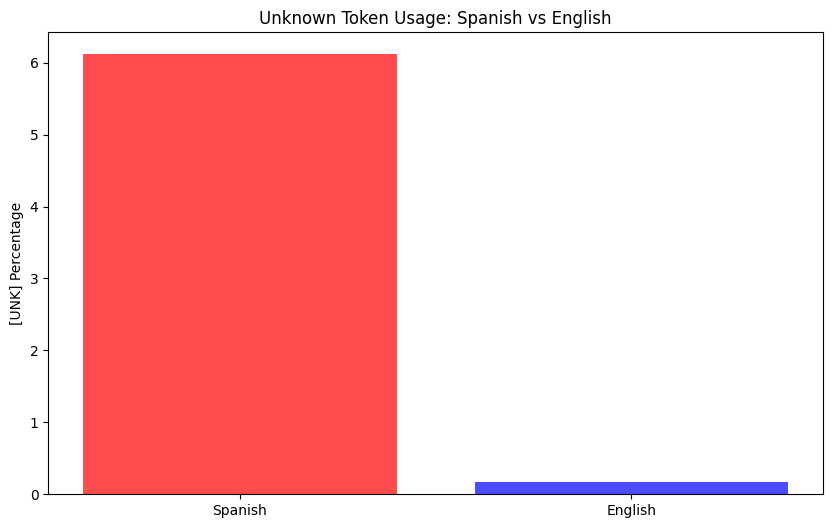

<Figure size 640x480 with 0 Axes>

In [39]:
# Compare [UNK] usage between languages
def compare_unk_usage(spanish_processor, english_processor, spanish_texts, english_texts):
    """Compare [UNK] usage between Spanish and English"""
    def count_unks(processor, texts):
        vocab = processor.get_vocabulary()
        unk_id = vocab.index('[UNK]') if '[UNK]' in vocab else None
        if unk_id is None:
            return 0, 0
        
        unk_count = 0
        total_tokens = 0
        
        for text in texts[:1000]:
            tokens = processor([text])
            token_array = tokens[0].numpy()
            unk_count += sum(1 for t in token_array if t == unk_id)
            total_tokens += sum(1 for t in token_array if t != 0)
        
        return unk_count, total_tokens
    
    sp_unks, sp_total = count_unks(spanish_processor, spanish_texts)
    en_unks, en_total = count_unks(english_processor, english_texts)
    
    sp_percentage = (sp_unks / sp_total) * 100 if sp_total > 0 else 0
    en_percentage = (en_unks / en_total) * 100 if en_total > 0 else 0
    
    print("=== [UNK] COMPARISON ===")
    print(f"Spanish [UNK]: {sp_unks}/{sp_total} ({sp_percentage:.3f}%)")
    print(f"English [UNK]: {en_unks}/{en_total} ({en_percentage:.3f}%)")
    
    # Visualize
    plt.figure(figsize=(10, 6))
    plt.bar(['Spanish', 'English'], [sp_percentage, en_percentage], 
            color=['red', 'blue'], alpha=0.7)
    plt.ylabel('[UNK] Percentage')
    plt.title('Unknown Token Usage: Spanish vs English')
    plt.show()
    plt.savefig("assets/unk_usage_comparison.png")

compare_unk_usage(context_text_processor, target_text_processor, context_raw, target_raw)

Now these layers can convert a batch of strings into a batch of token IDs:

In [40]:
# Convert the batch of example context strings (Spanish sentences) into token IDs using the context_text_processor
example_tokens = context_text_processor(example_context_strings)

# Display the token IDs for the first 3 sentences in the batch
example_tokens[:3, :]

<tf.RaggedTensor [[2, 559, 75, 62, 1, 6, 97, 164, 11, 171, 688, 4, 3],
 [2, 9, 540, 500, 4, 3], [2, 1, 4, 3]]>

The `get_vocabulary` method can be used to convert token IDs back to text:

In [41]:
# Get the vocabulary from the context_text_processor as a numpy array
context_vocab = np.array(context_text_processor.get_vocabulary())

# Convert the first example's token IDs to their corresponding words using the vocabulary
tokens = context_vocab[example_tokens[0].numpy()]

# Join the tokens into a single string for readability
' '.join(tokens)

'[START] pase mucho tiempo [UNK] de ese problema la semana pasada . [END]'

The returned token IDs are zero-padded. This can easily be turned into a mask:

---

### Why masking is important 🛡️

Token sequences are padded with zeros to ensure all sequences in a batch have the same length. These padding tokens do **not** represent actual data and should be ignored during computations such as loss calculation, accuracy measurement, and attention visualization.

Without masking, the model would treat padding as meaningful input, introducing noise and bias that can negatively affect training and evaluation. The mask allows us to focus only on the real tokens, ensuring that metrics and model updates are based solely on valid data. ✅

**In summary:**  
- Padding tokens = 🚫 not real data  
- Masking = 🕵️‍♂️ focus on valid tokens  
- Better training & evaluation = 🎯

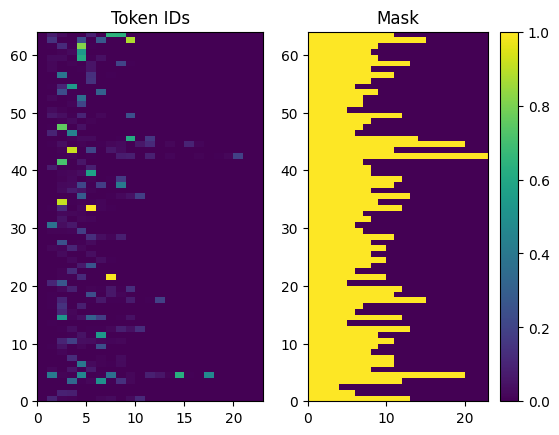

In [42]:
# If running in a Jupyter notebook, ensure plots display inline
%matplotlib inline

# Plot the token IDs for the batch of example sentences.
plt.subplot(1, 2, 1)
plt.pcolormesh(example_tokens.to_tensor())  # Convert ragged tensor to dense and plot token IDs
plt.title('Token IDs')

# Plot the mask showing which positions are non-padding (token ID != 0)
plt.subplot(1, 2, 2)
plt.pcolormesh(example_tokens.to_tensor() != 0)  # True for non-padding tokens
# include color bar
plt.colorbar()
plt.title('Mask')
plt.savefig("assets/token_ids_and_mask.png")

### Explanation of the Two Figures Above 📊

The two figures above provide insights into the tokenization and masking process for the context sequences:

1. **Token IDs Plot**:
    - This figure visualizes the token IDs for a batch of context sequences (Spanish sentences).
    - Each row represents a sequence, and each column corresponds to a token position within that sequence.
    - The values in the plot are the token IDs assigned to each word or special token (e.g., `[START]`, `[END]`, `[UNK]`).
    - The padding tokens (ID `0`) are used to ensure all sequences in the batch have the same length.

2. **Mask Plot**:
    - This figure shows the mask for the same batch of context sequences.
    - The mask indicates which positions in the sequences contain valid tokens (non-padding tokens).
    - Non-padding tokens are represented as `True` (or `1`), while padding tokens are represented as `False` (or `0`).
    - The mask is crucial for ensuring that padding tokens are ignored during computations like loss calculation and attention mechanisms.

Together, these plots help visualize how the tokenization and masking processes prepare the data for training, ensuring that the model focuses only on meaningful tokens. 🎯

### Process the dataset 🛠️✨

The `process_text` function below converts the `Datasets` of strings, into  0-padded tensors of token IDs. It also converts from a `(context, target)` pair to an `((context, target_in), target_out)` pair for training with `keras.Model.fit`. Keras expects `(inputs, labels)` pairs, the inputs are the `(context, target_in)` and the labels are `target_out`. The difference between `target_in` and `target_out` is that they are shifted by one step relative to eachother, so that at each location the label is the next token. 🧩🔢

In [43]:
def process_text(context, target):
  # Convert context sentences (Spanish) to token IDs and pad to tensor
  context = context_text_processor(context).to_tensor()
  # Convert target sentences (English) to token IDs (ragged tensor)
  target = target_text_processor(target)
  # Prepare decoder input by removing the last token ([END])
  targ_in = target[:, :-1].to_tensor()
  # Prepare decoder output by removing the first token ([START])
  targ_out = target[:, 1:].to_tensor()
  # Return ((context, decoder_input), decoder_output) for training
  return (context, targ_in), targ_out

# Map the process_text function over the training and validation datasets
train_ds = train_raw.map(process_text, tf.data.AUTOTUNE)
val_ds = val_raw.map(process_text, tf.data.AUTOTUNE)

Here is the first sequence of each, from the first batch:

In [44]:
# Iterate over one batch from the training dataset
for (ex_context_tok, ex_tar_in), ex_tar_out in train_ds.take(1):
  # Print the first 10 token IDs of the first context (Spanish) sentence in the batch
  print(ex_context_tok[0, :10].numpy())
  print()
  # Print the first 10 token IDs of the first target (English) input sentence in the batch
  print(ex_tar_in[0, :10].numpy())
  # Print the first 10 token IDs of the first target (English) output sentence in the batch
  print(ex_tar_out[0, :10].numpy())

[   2    9   49  417    6 5072    4    3    0    0]

[  2   6  27 222  41   1   4   0   0   0]
[  6  27 222  41   1   4   3   0   0   0]


## The encoder/decoder 🤖📝

The following diagrams shows an overview of the model. In both the encoder is on the left, the decoder is on the right. At each time-step the decoder's output is combined with the encoder's output, to predict the next word.

The original [left] contains a few extra connections that are intentionally omitted from this tutorial's model [right], as they are generally unnecessary, and difficult to implement. Those missing connections are:

1. Feeding the state from the encoder's RNN to the decoder's RNN
2. Feeding the attention output back to the RNN's input.

<table>
<tr>
  <td>
   <img width=500 src="https://www.tensorflow.org/images/seq2seq/attention_mechanism.jpg"/>
  </td>
  <td>
   <img width=380 src="https://www.tensorflow.org/images/tutorials/transformer/RNN+attention.png"/>
  </td>
</tr>
<tr>
  <th colspan=1>The original from <a href=https://arxiv.org/abs/1508.04025v5>Effective Approaches to Attention-based Neural Machine Translation</a></th>
  <th colspan=1>This tutorial's model</th>
<tr>
</table>


### Explanation of the Encoder-Decoder Model for Translation

The encoder-decoder model is a sequence-to-sequence architecture commonly used for tasks like machine translation. It consists of two main components: the **encoder** and the **decoder**, which work together to transform an input sequence (e.g., a sentence in Spanish) into an output sequence (e.g., its translation in English).

---

#### **Encoder**
The encoder processes the input sequence and encodes it into a fixed-length representation, which captures the meaning of the entire sequence. This representation is then passed to the decoder. The encoder in this model has the following components:

1. **Embedding Layer**:
    - Converts input tokens (e.g., words) into dense vectors of fixed size.
    - These embeddings capture semantic relationships between words.

2. **Bidirectional GRU**:
    - Processes the sequence in both forward and backward directions.
    - Combines the outputs from both directions to create a context-aware representation of each token.
    - Outputs a sequence of vectors, one for each token in the input.

3. **Output**:
    - The encoder outputs a sequence of vectors, which will be used by the decoder for attention and translation.

---

#### **Decoder**
The decoder generates the output sequence one token at a time, using the encoder's output and its own previous predictions. The decoder has the following components:

1. **Embedding Layer**:
    - Converts the target tokens (e.g., English words) into dense vectors.

2. **Unidirectional GRU**:
    - Processes the target sequence step by step, keeping track of what has been generated so far.

3. **Attention Mechanism**:
    - Computes a weighted average of the encoder's output vectors, focusing on the most relevant parts of the input sequence for each output token.
    - This allows the decoder to "attend" to specific words in the input while generating the translation.

4. **Output Layer**:
    - A dense layer that predicts the next token in the sequence based on the decoder's current state and the attention output.

---

#### **Attention Mechanism**
The attention mechanism is a key component that improves the model's ability to handle long sequences. It allows the decoder to focus on specific parts of the input sequence at each step, rather than relying on a single fixed-length representation. This is particularly important for translation tasks, where the alignment between input and output tokens can vary.

---

#### **Training**
During training:
- The model is provided with both the input sequence (e.g., Spanish sentence) and the target sequence (e.g., English translation).
- The decoder is trained to predict the next token in the target sequence, given the input sequence and the previous tokens in the target sequence.

---

#### **Inference**
During inference:
- The encoder processes the input sequence and generates its representation.
- The decoder generates the output sequence one token at a time, using the encoder's output and its own predictions.

---

#### **Advantages**
- The encoder-decoder architecture is flexible and can handle variable-length input and output sequences.
- The attention mechanism improves the model's ability to focus on relevant parts of the input, leading to better translations.

This architecture is widely used in natural language processing tasks, including translation, summarization, and question answering.

Before getting into it define constants for the model:

In [45]:
# Set the number of units (dimensions) for the model's internal representations.
# This value is used for the size of the RNN hidden state and embedding vectors.
UNITS = 256

### The encoder 🤖

The goal of the encoder is to process the context sequence into a sequence of vectors that are useful for the decoder as it attempts to predict the next output for each timestep. Since the context sequence is constant (meaning we know the full sentence before any processing takes place), there is no restriction on how information can flow in the encoder (the encoder can access any word in the sentence at any time). Therefore, we use a bidirectional-RNN to do the processing:

<table>
<tr>
  <td>
   <img width=500 src="https://tensorflow.org/images/tutorials/transformer/RNN-bidirectional.png"/>
  </td>
</tr>
<tr>
  <th>A bidirectional RNN</th>
<tr>
</table>

The encoder:

1. Takes a list of token IDs (from `context_text_processor`). 🆔 
2. Looks up an embedding vector for each token (Using a `layers.Embedding`). 🧩
3. Processes the embeddings into a new sequence (Using a bidirectional `layers.GRU`). 🔄 
4. Returns the processed sequence. This will be passed to the attention head. 🎯

## 🧠 Understanding the Embedding Matrix

### What is the Embedding Matrix?

The **embedding matrix** is a learnable lookup table that converts discrete token IDs (integers) into dense vector representations. It's the foundation that allows neural networks to work with meaningful word representations instead of arbitrary numbers.

- Each dimension (column) captures a different linguistic feature
- Each value represents how much that word exhibits that feature
- Positive values = strong presence of the feature
- Negative values = strong absence of the feature
- Values near zero = neutral/irrelevant for that feature

Example features include whether a word is an adjective/verb/noun, masculine/feminine, past/present/future, etc. The features are learned representions and do **NOT** have explicit, interpretable meanings. In machine learning, this is called a black-box process.

In [46]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, text_processor, units):
    super(Encoder, self).__init__()
    # Store the text processor and model units
    self.text_processor = text_processor
    self.vocab_size = text_processor.vocabulary_size()
    self.units = units

    # Embedding layer: Converts token IDs to dense vectors
    self.embedding = tf.keras.layers.Embedding(self.vocab_size, units,
                                               mask_zero=True)

    # Bidirectional GRU: Processes the sequence of embeddings
    # Bidirectional GRU: merge_mode='sum' combines the outputs from the forward and backward RNNs by summing them.
    # This keeps the output dimension the same as 'units', making it easier to use in downstream layers.
    self.rnn = tf.keras.layers.Bidirectional(
      merge_mode='sum',
      layer=tf.keras.layers.GRU(units,
                # Return the full sequence and final state
                return_sequences=True,
                recurrent_initializer='glorot_uniform'))

  def call(self, x):
    # Check input shape: (batch, sequence_length)
    shape_checker = ShapeChecker()
    shape_checker(x, 'batch s')

    # Convert token IDs to embeddings: (batch, sequence_length, units)
    x = self.embedding(x)
    shape_checker(x, 'batch s units')

    # Process embeddings with bidirectional GRU: (batch, sequence_length, units)
    x = self.rnn(x)
    shape_checker(x, 'batch s units')

    # Return processed sequence for attention
    return x

  def convert_input(self, texts):
    # Convert input texts to tensor
    texts = tf.convert_to_tensor(texts)
    # If input is a scalar, add batch dimension
    if len(texts.shape) == 0:
      texts = tf.convert_to_tensor(texts)[tf.newaxis]
    # Tokenize and pad input texts
    context = self.text_processor(texts).to_tensor()
    # Encode the tokenized input
    context = self(context)
    return context

### Important Limitation: Features Are Not Interpretable! ⚠️

You're absolutely correct! While we can theoretically describe what *types* of features embeddings might capture, **we cannot directly interpret what specific columns (dimensions) represent**. For example:

- **Column 1** might encode some combination of grammatical and semantic information
- **Column 2** might capture entirely different linguistic patterns
- **Columns 1-50** might work together to represent gender and tense

The embedding matrix is a **"black box"** - the model learns these representations automatically during training, but they're not human-interpretable. Let's explore what we *can* observe about the embedding matrix:

In [47]:
# Let's examine the embedding matrix after the model is trained
def analyze_embedding_matrix(model, text_processor, vocab_size_limit=50):
    """
    Analyze the embedding matrix to see what we can (and cannot) interpret
    """
    # Get the embedding weights from the encoder
    embedding_weights = model.encoder.embedding.get_weights()[0]
    vocab = text_processor.get_vocabulary()
    
    print(f"Embedding Matrix Shape: {embedding_weights.shape}")
    print(f"- Rows (vocabulary): {embedding_weights.shape[0]} words")
    print(f"- Columns (features): {embedding_weights.shape[1]} dimensions")
    print(f"- Each cell contains a learned weight value")
    
    # Look at a sample of the embedding matrix
    print(f"\n=== SAMPLE OF EMBEDDING MATRIX (first {vocab_size_limit} words, first 10 dimensions) ===")
    
    # Create a visualization of the embedding matrix
    plt.figure(figsize=(12, 8))
    
    # Show the first vocab_size_limit words and first 20 dimensions
    sample_embeddings = embedding_weights[:vocab_size_limit, :20]
    
    plt.imshow(sample_embeddings, aspect='auto', cmap='RdBu', vmin=-1, vmax=1)
    plt.colorbar(label='Embedding Value')
    plt.xlabel('Embedding Dimensions (Columns 0-19)')
    plt.ylabel('Vocabulary Words (First 50)')
    plt.title('Embedding Matrix Visualization: What Do These Numbers Mean?')
    
    # Add some word labels on the y-axis for context
    word_labels = [vocab[i] if i < len(vocab) else f'token_{i}' for i in range(min(20, vocab_size_limit))]
    plt.yticks(range(min(20, vocab_size_limit)), word_labels)
    
    plt.tight_layout()
    plt.show()
    plt.savefig("assets/embedding_matrix_visualization.png")
    
    # Show some specific examples
    print(f"\n=== SPECIFIC EXAMPLES ===")
    interesting_words = ['[START]', '[END]', 'el', 'la', 'es', 'casa', 'hola', '[UNK]']
    
    for word in interesting_words:
        if word in vocab:
            word_idx = vocab.index(word)
            embedding_vec = embedding_weights[word_idx]
            print(f"\nWord: '{word}' (index {word_idx})")
            print(f"First 10 dimensions: {embedding_vec[:10]}")
            print(f"Dimension 0: {embedding_vec[0]:.3f}")
            print(f"Dimension 1: {embedding_vec[1]:.3f}")
            print(f"→ But we DON'T know what dimensions 0 and 1 represent!")

# Only run this after the model is trained
if 'model' in locals():
    analyze_embedding_matrix(model, context_text_processor)

In [48]:
# What we CAN analyze: Word similarities in embedding space
def find_similar_words(model, text_processor, target_word, top_k=5):
    """
    Find words that are similar in embedding space to a target word.
    This gives us SOME insight into what the model has learned, but still
    doesn't tell us what specific dimensions mean.
    """
    import numpy as np
    from sklearn.metrics.pairwise import cosine_similarity
    
    embedding_weights = model.encoder.embedding.get_weights()[0]
    vocab = text_processor.get_vocabulary()
    
    if target_word not in vocab:
        print(f"Word '{target_word}' not in vocabulary")
        return
    
    target_idx = vocab.index(target_word)
    target_embedding = embedding_weights[target_idx].reshape(1, -1)
    
    # Calculate cosine similarity with all other words
    similarities = cosine_similarity(target_embedding, embedding_weights)[0]
    
    # Get top-k most similar words (excluding the word itself)
    similar_indices = np.argsort(similarities)[::-1][1:top_k+1]
    
    print(f"\n=== WORDS MOST SIMILAR TO '{target_word}' IN EMBEDDING SPACE ===")
    print("(This shows what the model has learned, but doesn't explain WHY)")
    
    for i, idx in enumerate(similar_indices):
        word = vocab[idx]
        similarity = similarities[idx]
        print(f"{i+1}. '{word}' (similarity: {similarity:.3f})")
    
    return similarities

# Demonstrate what we CAN and CANNOT learn from embeddings
def demonstrate_embedding_analysis(model, text_processor):
    """Show the limitations and possibilities of embedding analysis"""
    
    print("🔍 WHAT WE CAN ANALYZE:")
    print("- Word similarities (which words are close in embedding space)")
    print("- Clustering of related words")
    print("- Some semantic relationships")
    
    print("\n❌ WHAT WE CANNOT DETERMINE:")
    print("- What dimension 0, 1, 2, etc. specifically represent") 
    print("- Why certain numbers appear in certain positions")
    print("- Direct interpretation of individual embedding values")
    
    # Show some examples if model exists
    if hasattr(model, 'encoder'):
        print("\n" + "="*60)
        
        # Find similar words for some examples
        test_words = ['casa', 'el', 'es', 'hola']
        for word in test_words:
            try:
                find_similar_words(model, text_processor, word, top_k=3)
            except:
                print(f"Could not analyze '{word}'")

# Only run after model is trained
if 'model' in locals():
    demonstrate_embedding_analysis(model, context_text_processor)

### Why Can't We Interpret Individual Dimensions? 🤔

The embedding matrix learns **distributed representations**, meaning:

1. **No Single Feature Per Column**: Column 1 doesn't represent "gender" and column 2 doesn't represent "tense". Instead, linguistic features are spread across multiple dimensions.

2. **Entangled Information**: Gender, tense, semantic meaning, and syntax are all mixed together across all 256 dimensions in complex ways.

3. **Non-Linear Combinations**: The model learns to combine dimensions non-linearly, so the meaning emerges from complex interactions between many dimensions.

4. **Random Initialization**: The model starts with random weights, so there's no predetermined meaning for any dimension.

### What This Means for Your Question 📊

- **Column 1**: Contains some mixture of linguistic information, but we can't say "this is the gender column"
- **Column 2**: Contains different linguistic information, possibly overlapping with column 1
- **Columns 1-256**: Work together as a team to represent each word's meaning

The power of embeddings comes from this **distributed representation** - it's more flexible than having predefined feature columns, but it sacrifices interpretability.

Try it out:

In [49]:
import os
import tensorflow as tf

# Disable oneDNN optimizations
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'

# Create an Encoder instance using the Spanish text processor and model units.
encoder = Encoder(context_text_processor, UNITS)

# Pass the batch of context token IDs through the encoder to get the encoded sequence.
ex_context = encoder(ex_context_tok)

# Print the shape of the input context tokens (batch size, sequence length).
print(f'Context tokens, shape (batch, s): {ex_context_tok.shape}')

# Print the shape of the encoder output (batch size, sequence length, units).
print(f'Encoder output, shape (batch, s, units): {ex_context.shape}')

2025-10-09 17:47:34.116399: E tensorflow/core/util/util.cc:131] oneDNN supports DT_BOOL only on platforms with AVX-512. Falling back to the default Eigen-based implementation if present.


Context tokens, shape (batch, s): (64, 21)
Encoder output, shape (batch, s, units): (64, 21, 256)


### The attention layer 🧠✨

The decoder needs to generate English words one by one, but it should be able to look at the entire Spanish sentence to determine the best translation. The attention layer lets the decoder access the information extracted by the encoder. It computes a vector from the entire context sequence, and adds that to the decoder's output. In essence, the attention layer tells the model which words are most important in a given context vector (Spanish sentence), rather than treating all words as equally important.

The simplest way you could calculate a single vector from the entire sequence would be to take the average across the sequence (`layers.GlobalAveragePooling1D`). An attention layer is similar, but calculates a **weighted** average across the context sequence. Where the weights are calculated from the combination of context and "query" vectors.

<table>
<tr>
  <td>
   <img width=500 src="https://www.tensorflow.org/images/tutorials/transformer/CrossAttention-new-full.png"/>
  </td>
</tr>
<tr>
  <th colspan=1>The attention layer</th>
<tr>
</table>

### Explanation of Key, Value, and Query in Attention Mechanism

In the attention mechanism, the concepts of **Key**, **Value**, and **Query** are central to how the model determines which parts of the input sequence to focus on when generating each output token. Here's what they represent:

1. **Query**:
    - The **query** is the vector that represents the current token in the target sequence (e.g., the token being generated by the decoder).
    - It is used to "ask" which parts of the input sequence (context) are most relevant for generating the current token.
    - In the diagram, the query comes from the decoder's output at the current time step.

2. **Key**:
    - The **key** is a vector representation of each token in the input sequence (context).
    - It is used to "match" against the query to determine the relevance of each input token for the current output token.
    - In the diagram, the keys are derived from the encoder's output.

3. **Value**:
    - The **value** is also a vector representation of each token in the input sequence (context).
    - It contains the actual information that will be used to compute the attention output.
    - In the diagram, the values are derived from the encoder's output, similar to the keys.

### How They Work Together:
- The attention mechanism computes a **similarity score** between the query and each key. This score determines how much "attention" the model should pay to each input token.
- These scores are normalized (using softmax) to produce a probability distribution over the input tokens.
- The values are then weighted by these scores, and the weighted sum is computed to produce the **attention output**.
- This output is a context-aware representation that combines information from the most relevant input tokens, helping the model generate the next token in the target sequence.

In summary:
- **Query**: What the model is looking for (decoder's current state).
- **Key**: What the input tokens represent (encoder's output).
- **Value**: The information content of the input tokens (encoder's output). 🎯✨

### Explanation of the Attention Layer's Rows and Columns

The attention layer computes a matrix of attention weights, which is a 2D tensor with the shape `(target_sequence_length, context_sequence_length)` for each example in the batch. Here's what the rows and columns represent:

1. **Rows (Target Sequence)**:
    - Each row corresponds to a token in the target sequence (e.g., English sentence being generated).
    - The number of rows equals the length of the target sequence.
    - Each row contains the attention weights for that specific target token, indicating how much the model "attends" to each token in the context sequence.

2. **Columns (Context Sequence)**:
    - Each column corresponds to a token in the context sequence (e.g., Spanish sentence being translated).
    - The number of columns equals the length of the context sequence.
    - Each column contains the attention weights for that specific context token, showing its importance for all target tokens.

### Key Points:
- The values in each row sum to 1, as they represent a probability distribution over the context sequence.
- Higher values in a row indicate that the model is focusing more on those specific context tokens when generating the corresponding target token.
- The attention mechanism allows the model to dynamically focus on different parts of the input sequence for each output token, improving translation quality and interpretability.

### Deep Dive: What's the Difference Between Key and Value? 🔍

This is a concept that frequently confuses people! 

#### The Key-Value Concept Analogy 🗝️📚
Think of it like a **dictionary or database lookup**:
- **Key**: The "search term" you use to find information
- **Value**: The actual "information content" you retrieve
- **Query**: What you're "searching for"

In this translation model, both keys and values come from the encoder output but store different values with different meanings. 

**Keys and Values both come from the encoder output, but serve different purposes:**

1. **Keys (🗝️)**: 
   - **Purpose**: Used for **matching/similarity** with the query
   - **Computation**: Often the encoder output passed through a linear transformation
   - **Used for**: Computing attention weights (how much to focus on each input word)

2. **Values (📦)**:
   - **Purpose**: Contains the **actual information** to be retrieved
   - **Computation**: Also encoder output, but may use different linear transformation
   - **Used for**: Computing the final attention output (the actual content)

#### Why Separate Key and Value? 🤔

**Flexibility**: The model can learn to:
- Use **Keys** to determine **"what's relevant"** (matching/attention weights)
- Use **Values** to provide **"what information to extract"** (content retrieval)

This separation allows the attention mechanism to be more sophisticated than just "copy the most similar input".

In [50]:
# Let's demonstrate Key vs Value with a concrete example
def demonstrate_key_value_computation():
    """
    Show exactly how Keys and Values are computed and what their values mean
    """
    print("=== KEY vs VALUE COMPUTATION DEMONSTRATION ===\n")
    
    # Simulate encoder output (this would be the actual encoder output in your model)
    batch_size, seq_len, units = 2, 4, 6  # Small example for clarity
    
    # Simulated encoder output (context)
    import numpy as np
    np.random.seed(42)  # For reproducible example
    encoder_output = tf.constant(np.random.randn(batch_size, seq_len, units), dtype=tf.float32)
    
    print(f"Encoder Output Shape: {encoder_output.shape}")
    print(f"Encoder Output (first sequence, first 3 positions):")
    for i in range(min(3, seq_len)):
        print(f"  Position {i}: {encoder_output[0, i, :].numpy()}")
    
    print("\n" + "="*60)
    
    # In MultiHeadAttention, Keys and Values are computed like this:
    # (Simplified version - the actual implementation has more complexity)
    
    # Key computation: Linear transformation of encoder output
    key_layer = tf.keras.layers.Dense(units, name="key_projection")
    keys = key_layer(encoder_output)
    
    # Value computation: Different linear transformation of encoder output  
    value_layer = tf.keras.layers.Dense(units, name="value_projection")
    values = value_layer(encoder_output)
    
    print("KEYS (after linear transformation):")
    print(f"Keys Shape: {keys.shape}")
    for i in range(min(3, seq_len)):
        print(f"  Key {i}: {keys[0, i, :].numpy()}")
    
    print(f"\nVALUES (after different linear transformation):")
    print(f"Values Shape: {values.shape}")
    for i in range(min(3, seq_len)):
        print(f"  Value {i}: {values[0, i, :].numpy()}")
    
    print("\n" + "="*60)
    print("KEY INSIGHTS:")
    print("1. Keys & Values start from the SAME encoder output")
    print("2. They go through DIFFERENT linear transformations (different learned weights)")
    print("3. Keys are used for SIMILARITY computation (attention weights)")
    print("4. Values are used for INFORMATION retrieval (final output)")
    print("5. The VALUES of these vectors are learned parameters - no direct human interpretation!")

# Run the demonstration
demonstrate_key_value_computation()

=== KEY vs VALUE COMPUTATION DEMONSTRATION ===

Encoder Output Shape: (2, 4, 6)
Encoder Output (first sequence, first 3 positions):
  Position 0: [ 0.49671414 -0.1382643   0.64768857  1.5230298  -0.23415338 -0.23413695]
  Position 1: [ 1.5792128   0.7674347  -0.46947438  0.54256004 -0.46341768 -0.46572974]
  Position 2: [ 0.24196227 -1.9132802  -1.7249179  -0.5622875  -1.0128311   0.31424734]

KEYS (after linear transformation):
Keys Shape: (2, 4, 6)
  Key 0: [-0.64557815 -1.3238035  -0.67892474  0.9860515   0.2244149   1.0745775 ]
  Key 1: [ 0.16256812 -0.45773402 -0.45287117  0.7032868   0.20952539  1.929189  ]
  Key 2: [-1.4540595   1.4384841   1.2295961  -0.5905651  -0.67696816 -0.5339052 ]

VALUES (after different linear transformation):
Values Shape: (2, 4, 6)
  Value 0: [ 0.45886853  0.18914527  0.3703011  -0.8125894  -0.58983225 -0.7374063 ]
  Value 1: [ 2.0031383 -0.7920067 -0.1938694 -0.7040067 -0.913051   0.2789223]
  Value 2: [ 1.2488793   0.6287982   1.7119597   1.7134593 

In [51]:
# Visual demonstration of the complete attention process
def demonstrate_attention_computation():
    """
    Show step-by-step how Query, Key, Value interact in attention
    """
    print("=== COMPLETE ATTENTION COMPUTATION STEP-BY-STEP ===\n")
    
    # Simple example with small dimensions for clarity
    seq_len, units = 3, 4
    
    # Example vectors (simplified)
    query = tf.constant([[1.0, 0.5, -0.2, 0.8]], dtype=tf.float32)  # Shape: (1, units)
    keys = tf.constant([
        [0.9, 0.3, -0.1, 0.7],   # Key for word 1
        [0.2, 1.0, 0.4, -0.3],   # Key for word 2  
        [0.6, -0.2, 0.8, 0.5]    # Key for word 3
    ], dtype=tf.float32)  # Shape: (seq_len, units)
    
    values = tf.constant([
        [2.1, -1.0, 0.5, 1.2],   # Value for word 1 (different from key!)
        [0.8, 0.3, -0.7, 2.0],   # Value for word 2
        [1.5, 0.9, 1.1, -0.4]    # Value for word 3
    ], dtype=tf.float32)  # Shape: (seq_len, units)
    
    print("INPUT VECTORS:")
    print(f"Query (what we're looking for):  {query[0].numpy()}")
    print(f"Key 1 (word 1 matching vector): {keys[0].numpy()}")
    print(f"Key 2 (word 2 matching vector): {keys[1].numpy()}")
    print(f"Key 3 (word 3 matching vector): {keys[2].numpy()}")
    print(f"Value 1 (word 1 content):       {values[0].numpy()}")
    print(f"Value 2 (word 2 content):       {values[1].numpy()}")
    print(f"Value 3 (word 3 content):       {values[2].numpy()}")
    
    print(f"\nSTEP 1: COMPUTE SIMILARITY SCORES (Query · Keys)")
    # Compute dot product between query and each key
    scores = tf.matmul(query, keys, transpose_b=True)  # Shape: (1, seq_len)
    print(f"Raw scores: {scores[0].numpy()}")
    
    print(f"\nSTEP 2: NORMALIZE TO GET ATTENTION WEIGHTS (Softmax)")
    attention_weights = tf.nn.softmax(scores, axis=-1)
    print(f"Attention weights: {attention_weights[0].numpy()}")
    print(f"(Notice they sum to 1: {tf.reduce_sum(attention_weights).numpy():.3f})")
    
    print(f"\nSTEP 3: COMPUTE WEIGHTED AVERAGE OF VALUES")
    # Weighted sum of values using attention weights
    attended_output = tf.matmul(attention_weights, values)  # Shape: (1, units)
    print(f"Final attention output: {attended_output[0].numpy()}")
    
    print(f"\nKEY INSIGHTS:")
    print(f"• Keys determined WHICH words to focus on (attention weights)")
    print(f"• Values provided the ACTUAL INFORMATION to extract")
    print(f"• Final output is a weighted combination of Values (not Keys!)")
    print(f"• The specific numbers are learned during training")

# Run the step-by-step demonstration
demonstrate_attention_computation()

=== COMPLETE ATTENTION COMPUTATION STEP-BY-STEP ===

INPUT VECTORS:
Query (what we're looking for):  [ 1.   0.5 -0.2  0.8]
Key 1 (word 1 matching vector): [ 0.9  0.3 -0.1  0.7]
Key 2 (word 2 matching vector): [ 0.2  1.   0.4 -0.3]
Key 3 (word 3 matching vector): [ 0.6 -0.2  0.8  0.5]
Value 1 (word 1 content):       [ 2.1 -1.   0.5  1.2]
Value 2 (word 2 content):       [ 0.8  0.3 -0.7  2. ]
Value 3 (word 3 content):       [ 1.5  0.9  1.1 -0.4]

STEP 1: COMPUTE SIMILARITY SCORES (Query · Keys)
Raw scores: [1.6299999  0.37999997 0.74      ]

STEP 2: NORMALIZE TO GET ATTENTION WEIGHTS (Softmax)
Attention weights: [0.58921945 0.1688142  0.24196637]
(Notice they sum to 1: 1.000)

STEP 3: COMPUTE WEIGHTED AVERAGE OF VALUES
Final attention output: [ 1.7353618  -0.32080546  0.4426028   0.94790524]

KEY INSIGHTS:
• Keys determined WHICH words to focus on (attention weights)
• Values provided the ACTUAL INFORMATION to extract
• Final output is a weighted combination of Values (not Keys!)
• The sp

### What Do the Values in Key/Value Vectors Actually Mean? 🎯

This brings us back to the same fundamental issue we discussed with embeddings:

#### **The Numbers Are Not Human-Interpretable** ❌

Just like with embedding dimensions, the specific values in Key and Value vectors:

- **Are learned during training** - not pre-defined by humans
- **Don't have direct meaning** - we can't say "dimension 0 represents gender"  
- **Work together as a system** - individual numbers don't mean much in isolation
- **Are optimized for the task** - the model learns whatever values help translation

#### **What We CAN Say** ✅

1. **Keys**: Learned representations optimized for **similarity matching**
   - Higher similarity between Query and Key → Higher attention weight
   - The exact numbers encode whatever patterns help identify relevance

2. **Values**: Learned representations optimized for **information content**  
   - Contains the information that gets extracted when attention weight is high
   - The exact numbers encode whatever information helps generate good translations

3. **Both are derived from encoder output** but transformed differently to serve their specific roles

#### **The Big Picture** 🌟

- **Key vectors**: "Here's how to recognize if I'm relevant"
- **Value vectors**: "Here's the information I contain"  
- **Query vector**: "Here's what I'm looking for"

The beauty of attention is that the model **automatically learns** the best Key/Value representations for translation, but this comes at the cost of human interpretability of individual vector values! 🤖✨

In [52]:
class CrossAttention(tf.keras.layers.Layer):
  def __init__(self, units, **kwargs):
    super().__init__()
    # Multi-head attention layer (single head, key_dim=units)
    self.mha = tf.keras.layers.MultiHeadAttention(key_dim=units, num_heads=1, **kwargs)
    # Layer normalization for output stability
    self.layernorm = tf.keras.layers.LayerNormalization()
    # Add layer for residual connection
    # Residual connections help gradients flow through the network, improve training stability,
    # and allow the model to reuse the original input along with the attention output.
    self.add = tf.keras.layers.Add()

  def call(self, x, context):
    shape_checker = ShapeChecker()

    # x: target sequence embeddings (batch, t, units)
    shape_checker(x, 'batch t units')
    # context: encoder output (batch, s, units)
    shape_checker(context, 'batch s units')

    # Compute attention output and attention scores
    attn_output, attn_scores = self.mha(
        query=x,         # queries: target sequence
        value=context,   # values: context sequence (encoder output)
        return_attention_scores=True)

    # Check shapes after attention
    shape_checker(x, 'batch t units')
    shape_checker(attn_scores, 'batch heads t s')

    # Average over heads to get (batch, t, s) attention weights
    attn_scores = tf.reduce_mean(attn_scores, axis=1)
    shape_checker(attn_scores, 'batch t s')
    # Cache attention weights for later visualization
    self.last_attention_weights = attn_scores

    # Residual connection: add attention output to input
    x = self.add([x, attn_output])
    # Normalize output
    x = self.layernorm(x)

    # Return attended and normalized output
    return x

In [53]:
# Create an instance of the CrossAttention layer with the specified number of units
attention_layer = CrossAttention(UNITS)

# Create an embedding layer for the target (English) tokens
embed = tf.keras.layers.Embedding(
    target_text_processor.vocabulary_size(),  # Vocabulary size for target language
    output_dim=UNITS,                        # Embedding dimension
    mask_zero=True                           # Mask padding tokens
)

# Embed the input target tokens (decoder input)
ex_tar_embed = embed(ex_tar_in)

# Apply the attention layer: attend to the encoded context using the embedded target tokens
result = attention_layer(ex_tar_embed, ex_context)

# Print the shapes of the input and output tensors for verification
print(f'Context sequence, shape (batch, s, units): {ex_context.shape}')           # Encoder output
print(f'Target sequence, shape (batch, t, units): {ex_tar_embed.shape}')          # Embedded target input
print(f'Attention result, shape (batch, t, units): {result.shape}')               # Output of attention layer
print(f'Attention weights, shape (batch, t, s):    {attention_layer.last_attention_weights.shape}')  # Attention scores

Context sequence, shape (batch, s, units): (64, 21, 256)
Target sequence, shape (batch, t, units): (64, 18, 256)
Attention result, shape (batch, t, units): (64, 18, 256)
Attention weights, shape (batch, t, s):    (64, 18, 21)


The attention weights will sum to `1` over the context sequence, at each location in the target sequence.

In [54]:
# Sum the attention weights over the context sequence for the first example in the batch.
# This checks that the attention weights for each target token sum to 1 (as expected for a probability distribution).
attention_layer.last_attention_weights[0].numpy().sum(axis=-1)

array([0.9999999 , 1.        , 1.        , 1.0000001 , 0.99999994,
       1.        , 0.99999994, 0.9999998 , 0.9999998 , 0.9999998 ,
       0.9999998 , 0.9999998 , 0.9999998 , 0.9999998 , 0.9999998 ,
       0.9999998 , 0.9999998 , 0.9999998 ], dtype=float32)



Here are the attention weights across the context sequences at `t=0`:

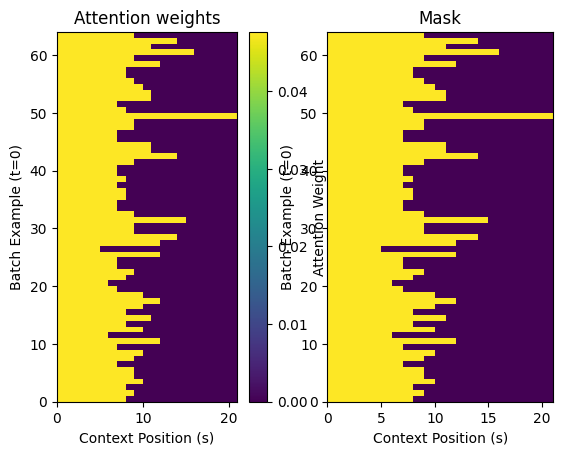

In [55]:
# Get the attention weights from the attention layer
attention_weights = attention_layer.last_attention_weights

# Create a mask for the context tokens (True for non-padding tokens)
mask = (ex_context_tok != 0).numpy()

# Plot the attention weights for the first target token, masked by valid context positions
plt.subplot(1, 2, 1)
plt.pcolormesh(mask * attention_weights[:, 0, :])
# add color bar to indicate weight scale
plt.colorbar(label='Attention Weight')
plt.title('Attention weights')
plt.xlabel('Context Position (s)')
plt.ylabel('Batch Example (t=0)')

# Plot the mask itself to show valid context positions
plt.subplot(1, 2, 2)
plt.pcolormesh(mask)
plt.title('Mask');
plt.xlabel('Context Position (s)')
plt.ylabel('Batch Example (t=0)')
plt.savefig("assets/attention_weights_and_mask.png")


🔍 **Interpreting Initial Attention Weights**

Because of the small-random initialization, the attention weights are initially all close to `1/(sequence_length)`.  
This means that, before training, the model does not "know" which parts of the input are important, so it distributes its attention almost uniformly across all positions in the context sequence.

As training progresses, the model learns to assign higher attention weights to the most relevant tokens in the input sequence for each output token.  
This non-uniform attention allows the model to focus on specific words or phrases that are most helpful for generating accurate translations, improving both the quality of the output and the interpretability of the attention mechanism. 🎯✨

### The decoder 🤖📝

The decoder's job is to generate predictions for the next token at each location in the target sequence.

1. It looks up embeddings for each token in the target sequence. 🧩
2. It uses an RNN to process the target sequence, and keep track of what it has generated so far. 🔄
3. It uses RNN output as the "query" to the attention layer, when attending to the encoder's output. 🎯
4. At each location in the output it predicts the next token. 📝

When training, the model predicts the next word at each location. So it's important that the information only flows in one direction through the model. The decoder uses a unidirectional (not bidirectional) RNN to process the target sequence.

When running inference with this model it produces one word at a time, and those are fed back into the model.

<table>
<tr>
  <td>
   <img width=500 src="https://tensorflow.org/images/tutorials/transformer/RNN.png"/>
  </td>
</tr>
<tr>
  <th>A unidirectional RNN</th>
<tr>
</table>

Here is the `Decoder` class' initializer. The initializer creates all the necessary layers.

In [56]:
class Decoder(tf.keras.layers.Layer):
  @classmethod
  def add_method(cls, fun):
    # Utility to add methods to the class dynamically (will be used after class object creation and dynamically add methods)
    setattr(cls, fun.__name__, fun)
    return fun

  def __init__(self, text_processor, units):
      super(Decoder, self).__init__()
      # Store the text processor and model units
      self.text_processor = text_processor
      self.vocab_size = text_processor.vocabulary_size()

      # Lookup layer: maps words to token IDs
      self.word_to_id = tf.keras.layers.StringLookup(
        vocabulary=text_processor.get_vocabulary(),
        mask_token='', oov_token='[UNK]')

      # Lookup layer: maps token IDs back to words
      self.id_to_word = tf.keras.layers.StringLookup(
        vocabulary=text_processor.get_vocabulary(),
        mask_token='', oov_token='[UNK]',
        invert=True)

      # Special token IDs for start and end of sequence
      self.start_token = self.word_to_id('[START]')
      self.end_token = self.word_to_id('[END]')

      self.units = units

      # 1. Embedding layer: converts token IDs to dense vectors
      self.embedding = tf.keras.layers.Embedding(
        self.vocab_size, units, mask_zero=True)

      # 2. RNN layer: processes the sequence and keeps track of generated tokens
      self.rnn = tf.keras.layers.GRU(
        units,
        return_sequences=True,
        return_state=True,
        recurrent_initializer='glorot_uniform'
      )

      # 3. Attention layer: attends to the encoder output using RNN output as query
      self.attention = CrossAttention(units)

      # 4. Output layer: produces logits for each output token
      self.output_layer = tf.keras.layers.Dense(self.vocab_size)

#### Training

Next, the `call` method, takes 3 arguments: 🤖

* `inputs` -  a `context, x` pair where:
  * `context` - is the context from the encoder's output. 🌐
  * `x` - is the target sequence input. 📝
* `state` - Optional, the previous `state` output from the decoder (the internal state of the decoder's RNN). Pass the state from a previous run to continue generating text where you left off. 🔄
* `return_state` - [Default: False] - Set this to `True` to return the RNN state. 🏁

In [57]:
@Decoder.add_method
def call(self,
  context, x,
  state=None,
  return_state=False):
    shape_checker = ShapeChecker()
    shape_checker(x, 'batch t')  # Check shape of target input tokens
    shape_checker(context, 'batch s units')  # Check shape of encoder output

    # 1. Lookup the embeddings for the target input tokens
    x = self.embedding(x)
    shape_checker(x, 'batch t units')  # Check shape after embedding

    # 2. Process the target sequence with the RNN
    x,state=self.rnn(x, initial_state=state)
    shape_checker(x, 'batch t units')  # Check shape after RNN

    # 3. Use the RNN output as the query for attention over the context
    x = self.attention(x, context)
    self.last_attention_weights = self.attention.last_attention_weights  # Cache attention weights for visualization
    shape_checker(x, 'batch t units')  # Check shape after attention
    shape_checker(self.last_attention_weights, 'batch t s')  # Check shape of attention weights

    # 4. Generate logit predictions for the next token
    logits = self.output_layer(x)
    shape_checker(logits, 'batch t target_vocab_size')  # Check shape of output logits

    # Optionally return the RNN state for inference
    if return_state:
     return logits, state
    else:
     return logits

That will be sufficient for training. Create an instance of the decoder to test out:

In [58]:
# Create an instance of the Decoder class using the target_text_processor and UNITS.
# The Decoder will be used to generate English translations from encoded Spanish context.
decoder = Decoder(target_text_processor, UNITS)

In training you'll use the decoder like this:

Given the context and target tokens, for each target token it predicts the next target token.

In [59]:
# Print the shapes of the encoder output, input target tokens, and logits for inspection
logits = decoder(ex_context, ex_tar_in)

# The encoder output shape: (batch, sequence_length, units)
print(f'encoder output shape: (batch, s, units) {ex_context.shape}')

# The input target tokens shape: (batch, target_sequence_length)
print(f'input target tokens shape: (batch, t) {ex_tar_in.shape}')

# The logits shape: (batch, target_sequence_length, target_vocabulary_size)
print(f'logits shape shape: (batch, target_vocabulary_size) {logits.shape}')

encoder output shape: (batch, s, units) (64, 21, 256)
input target tokens shape: (batch, t) (64, 18)
logits shape shape: (batch, target_vocabulary_size) (64, 18, 6000)


/home/zkhechadoorian/Spanish_and_Portuguese_Translator/.venv/lib/python3.12/site-packages/keras/src/layers/layer.py:421: UserWarning: `build()` was called on layer 'decoder', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/home/zkhechadoorian/Spanish_and_Portuguese_Translator/.venv/lib/python3.12/site-packages/keras/src/layers/layer.py:970: UserWarning: Layer 'cross_attention_1' (of type CrossAttention) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


#### Inference

To use it for inference you'll need a couple more methods:

In [60]:
@Decoder.add_method
def get_initial_state(self, context):
  # This method is needed for inference to initialize the decoder's generation loop.
  # It provides the initial start tokens, a mask indicating which sequences are finished,
  # and the initial RNN state for the decoder. This setup allows the model to begin
  # generating output tokens one step at a time, starting from the [START] token.

  batch_size = tf.shape(context)[0]
  start_tokens = tf.fill([batch_size, 1], self.start_token)
  done = tf.zeros([batch_size, 1], dtype=tf.bool)
  embedded = self.embedding(start_tokens)
  batch_size = tf.shape(embedded)[0]
  return start_tokens, done, self.rnn.get_initial_state(batch_size)[0]


In [61]:
@Decoder.add_method
def tokens_to_text(self, tokens):
  # During inference, the model generates sequences of token IDs.
  # This method converts those token IDs back to human-readable text.
  # It's needed in inference to interpret the model's output as actual sentences.

  # Convert token IDs to words using the id_to_word lookup layer
  words = self.id_to_word(tokens)
  # Join the words into sentences (strings), separating by spaces
  result = tf.strings.reduce_join(words, axis=-1, separator=' ')
  # Remove the [START] token from the beginning of each sentence
  result = tf.strings.regex_replace(result, '^ *\[START\] *', '')
  # Remove the [END] token from the end of each sentence
  result = tf.strings.regex_replace(result, ' *\[END\] *$', '')
  # Return the cleaned sentences as strings
  return result

<>:12: SyntaxWarning: invalid escape sequence '\['
<>:14: SyntaxWarning: invalid escape sequence '\['
<>:12: SyntaxWarning: invalid escape sequence '\['
<>:14: SyntaxWarning: invalid escape sequence '\['
/tmp/ipykernel_3306671/722425168.py:12: SyntaxWarning: invalid escape sequence '\['
  result = tf.strings.regex_replace(result, '^ *\[START\] *', '')
/tmp/ipykernel_3306671/722425168.py:14: SyntaxWarning: invalid escape sequence '\['
  result = tf.strings.regex_replace(result, ' *\[END\] *$', '')


In [62]:
@Decoder.add_method
def get_next_token(self, context, next_token, done, state, temperature = 0.0):
  # This method is needed for inference because, during generation,
  # we produce one token at a time, feeding the previous output back in.
  # It runs the decoder for a single step, predicts the next token,
  # and updates the RNN state and done mask for each sequence in the batch.

  # Run the decoder for one step to get logits and new RNN state
  logits, state = self(
    context, next_token,
    state = state,
    return_state=True)

  # If temperature is 0, use greedy decoding (argmax)
  if temperature == 0.0:
    next_token = tf.argmax(logits, axis=-1)
  else:
    # Otherwise, sample from the probability distribution (softmax with temperature)
    logits = logits[:, -1, :]/temperature
    next_token = tf.random.categorical(logits, num_samples=1)

  # Mark sequences as done if they produce the end token
  done = done | (next_token == self.end_token)
  # For finished sequences, pad with zeros
  next_token = tf.where(done, tf.constant(0, dtype=tf.int64), next_token)

  # Return the next token, done mask, and new state
  return next_token, done, state

With those extra functions, you can write a generation loop:

In [63]:
# Setup the loop variables for inference.
# Get initial decoder state, start tokens, and done mask for the batch.
next_token, done, state = decoder.get_initial_state(ex_context)
tokens = []

# Generate up to 10 tokens for each sequence in the batch.
for n in range(10):
  # Run one decoding step: get next token, update done mask and RNN state.
  next_token, done, state = decoder.get_next_token(
      ex_context, next_token, done, state, temperature=1.0)
  # Collect the generated token for this step.
  tokens.append(next_token)

# Concatenate all generated tokens along the sequence axis to form output sequences.
tokens = tf.concat(tokens, axis=-1) # (batch, t)

# Convert the token IDs back to text strings.
result = decoder.tokens_to_text(tokens)
# Display the first 3 generated sequences.
result[:3].numpy()

array([b'nuts ignorant leaned hearing gag parttime eat cameraman congratulate sponge',
       b'sooner lies defeated seats egg relative eighteen frozen inside action',
       b'remain winner ufo his invest candles french knows blankets placed'],
      dtype=object)

Since the model's untrained, it outputs items from the vocabulary almost uniformly at random.

## The model 🤖✨

Now that you have all the model components, combine them to build the model for training:

In [64]:
class Translator(tf.keras.Model):
  @classmethod
  def add_method(cls, fun):
    # Utility to add methods to the class dynamically
    setattr(cls, fun.__name__, fun)
    return fun

  def __init__(self, units,
               context_text_processor,
               target_text_processor):
    super().__init__()
    # Build the encoder and decoder using the provided text processors and units
    encoder = Encoder(context_text_processor, units)
    decoder = Decoder(target_text_processor, units)

    self.encoder = encoder
    self.decoder = decoder

  def call(self, inputs):
    # Unpack the inputs: context (source language) and x (target language input)
    context, x = inputs
    # Encode the context sequence
    context = self.encoder(context)
    # Decode the target input sequence using the encoded context
    logits = self.decoder(context, x)

    try:
      # Delete the keras mask, so keras doesn't scale the loss+accuracy.
      del logits._keras_mask
    except AttributeError:
      pass

    # Return the output logits (predictions for next token)
    return logits

During training the model will be used like this:

In [65]:
# Instantiate the Translator model with the specified number of units and text processors
model = Translator(UNITS, context_text_processor, target_text_processor)

# Pass a batch of context and target input tokens through the model to get output logits
logits = model((ex_context_tok, ex_tar_in))

# Print the shapes of the input and output tensors for inspection
print(f'Context tokens, shape: (batch, s, units) {ex_context_tok.shape}')  # Shape of context input tokens
print(f'Target tokens, shape: (batch, t) {ex_tar_in.shape}')              # Shape of target input tokens
print(f'logits, shape: (batch, t, target_vocabulary_size) {logits.shape}') # Shape of model output logits

/home/zkhechadoorian/Spanish_and_Portuguese_Translator/.venv/lib/python3.12/site-packages/keras/src/layers/layer.py:421: UserWarning: `build()` was called on layer 'decoder_1', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/home/zkhechadoorian/Spanish_and_Portuguese_Translator/.venv/lib/python3.12/site-packages/keras/src/layers/layer.py:970: UserWarning: Layer 'cross_attention_2' (of type CrossAttention) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


Context tokens, shape: (batch, s, units) (64, 21)
Target tokens, shape: (batch, t) (64, 18)
logits, shape: (batch, t, target_vocabulary_size) (64, 18, 6000)


/home/zkhechadoorian/Spanish_and_Portuguese_Translator/.venv/lib/python3.12/site-packages/keras/src/layers/layer.py:970: UserWarning: Layer 'decoder_1' (of type Decoder) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


### Training 🏋️‍♂️✨

For training, you'll want to implement your own masked loss and accuracy functions:

In [66]:
def masked_loss(y_true, y_pred):
    # Create a loss function for sparse categorical crossentropy.
    # from_logits=True means y_pred are raw logits, not probabilities.
    # reduction='none' means the loss is computed per element, not averaged.
    # SparseCategoricalCrossentropy is needed because the targets (y_true) are integer class labels (token IDs),
    # not one-hot encoded vectors. It efficiently computes the cross-entropy loss for each token prediction.
    loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction='none')

    # Compute the loss for each item in the batch.
    loss = loss_fn(y_true, y_pred)

    # Create a mask to ignore losses for padding tokens (where y_true == 0).
    mask = tf.cast(y_true != 0, loss.dtype)
    # Apply the mask to the loss.
    loss *= mask

    # Return the mean loss over all non-padding tokens.
    return tf.reduce_sum(loss) / tf.reduce_sum(mask)

In [67]:
def masked_acc(y_true, y_pred):
    # Compute the predicted token IDs by taking the argmax over the last axis (vocabulary dimension)
    y_pred = tf.argmax(y_pred, axis=-1)
    # Cast predictions to the same dtype as y_true for comparison
    y_pred = tf.cast(y_pred, y_true.dtype)

    # Compare predictions to true labels; 1.0 for match, 0.0 otherwise
    match = tf.cast(y_true == y_pred, tf.float32)
    # Create a mask to ignore padding tokens (where y_true == 0)
    mask = tf.cast(y_true != 0, tf.float32)

    # Compute the mean accuracy over all non-padding tokens
    return tf.reduce_sum(match) / tf.reduce_sum(mask)

Configure the model for training:

In [68]:
# Compile the model for training.
# - optimizer='adam': Use the Adam optimizer for training.
# - loss=masked_loss: Use the custom masked loss function to ignore padding tokens.
# - metrics=[masked_acc, masked_loss]: Track masked accuracy and masked loss during training.
model.compile(optimizer='adam',
              loss=masked_loss,
              metrics=[masked_acc, masked_loss])

The model is randomly initialized, and should give roughly uniform output probabilities. So it's easy to predict what the initial values of the metrics should be:

In [69]:
# Get the vocabulary size of the target language as a float
vocab_size = 1.0 * target_text_processor.vocabulary_size()

# Calculate the expected loss and accuracy for a randomly initialized model:
# - expected_loss: log(vocab_size), since the output probabilities are uniform
# - expected_acc: 1/vocab_size, since the chance of guessing the correct token is 1 out of vocab_size
{
    "expected_loss": tf.math.log(vocab_size).numpy(),
    "expected_acc": 1/vocab_size
}

{'expected_loss': np.float32(8.699514), 'expected_acc': 0.00016666666666666666}

That should roughly match the values returned by running a few steps of evaluation:

In [70]:
# Evaluate the model on the validation dataset.
# - val_ds: validation dataset, already processed and batched
# - steps=20: run evaluation for 20 batches
# - return_dict=True: return the results as a dictionary of metric names and values
model.evaluate(val_ds, steps=20, return_dict=True)

20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 8.7102 - masked_acc: 9.6899e-05 - masked_loss: 8.7102


{'loss': 8.710241317749023,
 'masked_acc': 9.689922444522381e-05,
 'masked_loss': 8.710241317749023}

In [71]:
# Train the model using the training dataset.
# - train_ds.repeat(): Repeat the training dataset indefinitely for multiple epochs.
# - epochs=100: Train for up to 100 epochs.
# - steps_per_epoch=100: Each epoch consists of 100 batches.
# - validation_data=val_ds: Use the validation dataset for evaluation.
# - validation_steps=20: Evaluate on 20 batches from the validation set each epoch.
# - callbacks=[tf.keras.callbacks.EarlyStopping(patience=3)]: Stop training early if validation loss doesn't improve for 3 epochs.
history = model.fit(
    train_ds.repeat(),
    epochs=100,
    steps_per_epoch=100,
    validation_data=val_ds,
    validation_steps=20,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=3)
    ]
)

Epoch 1/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 15s 75ms/step - loss: 4.9886 - masked_acc: 0.2889 - masked_loss: 4.9886 - val_loss: 4.0745 - val_masked_acc: 0.3604 - val_masked_loss: 4.0745
Epoch 2/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 8s 77ms/step - loss: 3.7249 - masked_acc: 0.4046 - masked_loss: 3.7249 - val_loss: 3.3926 - val_masked_acc: 0.4421 - val_masked_loss: 3.3926
Epoch 3/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 74ms/step - loss: 3.1502 - masked_acc: 0.4801 - masked_loss: 3.1502 - val_loss: 2.8136 - val_masked_acc: 0.5267 - val_masked_loss: 2.8136
Epoch 4/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 8s 75ms/step - loss: 2.7077 - masked_acc: 0.5439 - masked_loss: 2.7077 - val_loss: 2.4548 - val_masked_acc: 0.5772 - val_masked_loss: 2.4548
Epoch 5/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 75ms/step - loss: 2.3982 - masked_acc: 0.5868 - masked_loss: 2.3982 - val_loss: 2.2667 - val_masked_acc: 0.6069 - val_masked_loss: 2.2667
Epoch 6/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 8s 75ms/step - loss: 2.2136 - masked_acc: 0.6155

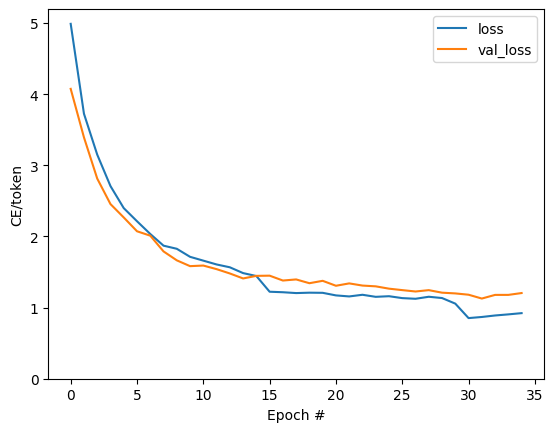

In [72]:
# Plot the training and validation loss curves over epochs.
plt.plot(history.history['loss'], label='loss')         # Training loss per epoch
plt.plot(history.history['val_loss'], label='val_loss') # Validation loss per epoch

# Set the y-axis limits to start at 0 and end at the maximum value currently shown.
plt.ylim([0, max(plt.ylim())])

# Label the x-axis as 'Epoch #' and y-axis as 'CE/token' (cross-entropy per token).
plt.xlabel('Epoch #')
plt.ylabel('CE/token')

# Add a legend to distinguish between training and validation loss curves.
plt.legend()
plt.savefig("assets/training_and_validation_loss.png")

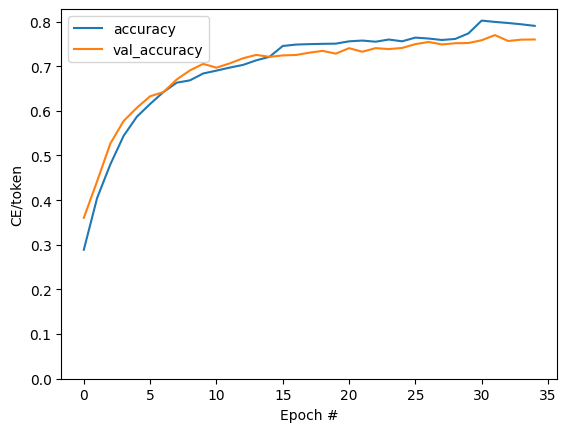

In [73]:
# Plot training accuracy over epochs
plt.plot(history.history['masked_acc'], label='accuracy')
# Plot validation accuracy over epochs
plt.plot(history.history['val_masked_acc'], label='val_accuracy')
# Set y-axis limits to start at 0 and end at the current maximum
plt.ylim([0, max(plt.ylim())])
# Label the x-axis as 'Epoch #'
plt.xlabel('Epoch #')
# Label the y-axis as 'CE/token' (cross-entropy per token)
plt.ylabel('CE/token')
# Add a legend to distinguish between training and validation accuracy
plt.legend()
plt.savefig("assets/training_and_validation_accuracy.png")

### Translate 🌍✨

Now that the model is trained, implement a function to execute the full `text => text` translation. This code is basically identical to the [inference example](#inference) in the [decoder section](#the_decoder), but this also captures the attention weights. 🧠🔤

In [74]:
#@title
@Translator.add_method
def translate(self,
              texts, *,
              max_length=50,
              temperature=0.0):
  # Process the input texts
  context = self.encoder.convert_input(texts)
  batch_size = tf.shape(texts)[0]

  # Setup the loop inputs
  tokens = []
  attention_weights = []
  next_token, done, state = self.decoder.get_initial_state(context)

  for _ in range(max_length):
    # Generate the next token
    next_token, done, state = self.decoder.get_next_token(
        context, next_token, done,  state, temperature)

    # Collect the generated tokens
    tokens.append(next_token)
    attention_weights.append(self.decoder.last_attention_weights)

    if tf.executing_eagerly() and tf.reduce_all(done):
      break

  # Stack the lists of tokens and attention weights.
  tokens = tf.concat(tokens, axis=-1)   # t*[(batch 1)] -> (batch, t)
  self.last_attention_weights = tf.concat(attention_weights, axis=1)  # t*[(batch 1 s)] -> (batch, t s)

  result = self.decoder.tokens_to_text(tokens)
  return result

Here are the two helper methods, used above, to convert tokens to text, and to get the next token:

In [75]:
# Translate the given Spanish sentence using the trained model.
result = model.translate(['Los libros pueden ser una forma de escapar de la realidad.']) # Are you still home

# Convert the first result from a TensorFlow tensor to a Python string and print it.
result[0].numpy().decode()

'books can be a form of escape . '

Use that to generate the attention plot:

In [76]:
#@title
@Translator.add_method
def plot_attention(self, text, **kwargs):
  # Ensure the input is a string
  assert isinstance(text, str)
  
  # We need to call translation WITHOUT @tf.function to avoid scope issues
  # Process the input texts manually to avoid the tf.function scope problem
  context = self.encoder.convert_input([text])
  batch_size = tf.shape(context)[0]

  # Setup the loop inputs
  tokens = []
  attention_weights = []
  next_token, done, state = self.decoder.get_initial_state(context)
  
  max_length = kwargs.get('max_length', 50)
  temperature = kwargs.get('temperature', 0.0)

  for _ in range(max_length):
    # Generate the next token
    next_token, done, state = self.decoder.get_next_token(
        context, next_token, done, state, temperature)

    # Collect the generated tokens
    tokens.append(next_token)
    attention_weights.append(self.decoder.last_attention_weights)

    if tf.executing_eagerly() and tf.reduce_all(done):
      break

  # Stack the lists of tokens and attention weights.
  tokens = tf.concat(tokens, axis=-1)   # t*[(batch 1)] -> (batch, t)
  attention_weights_tensor = tf.concat(attention_weights, axis=1)  # t*[(batch 1 s)] -> (batch, t s)

  # Convert tokens to text
  output = self.decoder.tokens_to_text(tokens)
  output = output[0].numpy().decode()

  # Get the attention weights for the first example (now accessible!)
  attention = attention_weights_tensor[0]

  # Tokenize and split the input context text
  context_text = tf_lower_and_split_punct(text)
  context_text = context_text.numpy().decode().split()

  # Tokenize and split the output text, skipping the [START] token
  output_text = tf_lower_and_split_punct(output)
  output_text = output_text.numpy().decode().split()[1:]

  # Create a figure for the attention plot
  fig = plt.figure(figsize=(10, 10))
  ax = fig.add_subplot(1, 1, 1)

  # Display the attention weights as an image
  ax.matshow(attention, cmap='viridis', vmin=0.0)

  # Set font size for axis labels
  fontdict = {'fontsize': 14}

  # Set x-axis labels to context tokens and rotate them
  ax.set_xticklabels([''] + context_text, fontdict=fontdict, rotation=90)
  # Set y-axis labels to output tokens
  ax.set_yticklabels([''] + output_text, fontdict=fontdict)

  # Set major tick locations to every token
  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

  # Label the axes
  ax.set_xlabel('Input text')
  ax.set_ylabel('Output text')

/tmp/ipykernel_3306671/149752333.py:62: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + context_text, fontdict=fontdict, rotation=90)
/tmp/ipykernel_3306671/149752333.py:64: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + output_text, fontdict=fontdict)


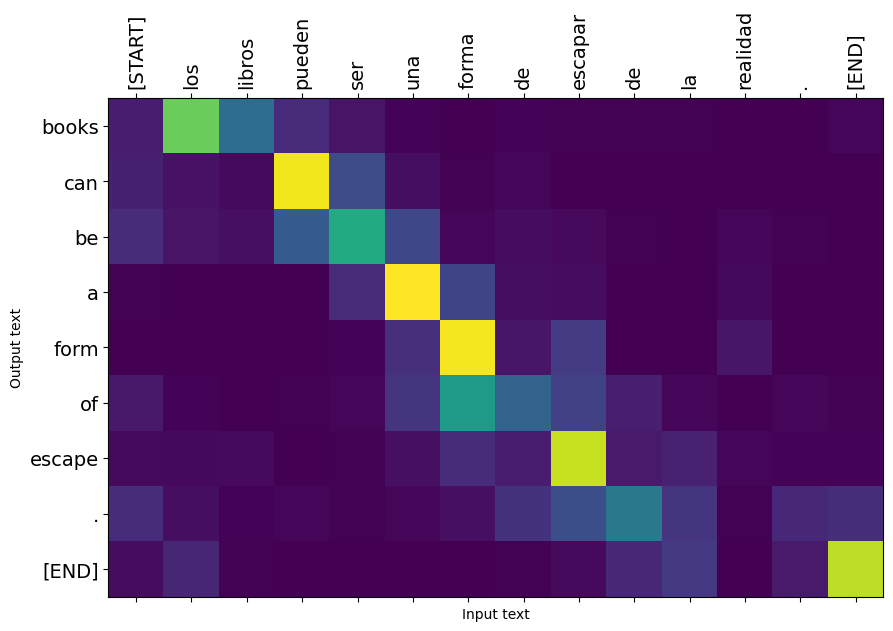

In [77]:
# Plot the attention weights for the translation of the given Spanish sentence.
# This will visualize which input words the model attends to when generating each output word.
model.plot_attention('Los libros pueden ser una forma de escapar de la realidad.') # Are you still home
plt.savefig("assets/attention_plot_los_libros.png")

Translate a few more sentences and plot them:

/home/zkhechadoorian/Spanish_and_Portuguese_Translator/.venv/lib/python3.12/site-packages/keras/src/layers/layer.py:970: UserWarning: Layer 'cross_attention_2' (of type CrossAttention) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/home/zkhechadoorian/Spanish_and_Portuguese_Translator/.venv/lib/python3.12/site-packages/keras/src/layers/layer.py:970: UserWarning: Layer 'decoder_1' (of type Decoder) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/tmp/ipykernel_3306671/149752333.py:62: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + context_text, fontdict=fontdict, rotation=90)
/tm

CPU times: user 408 ms, sys: 5.23 ms, total: 414 ms
Wall time: 401 ms


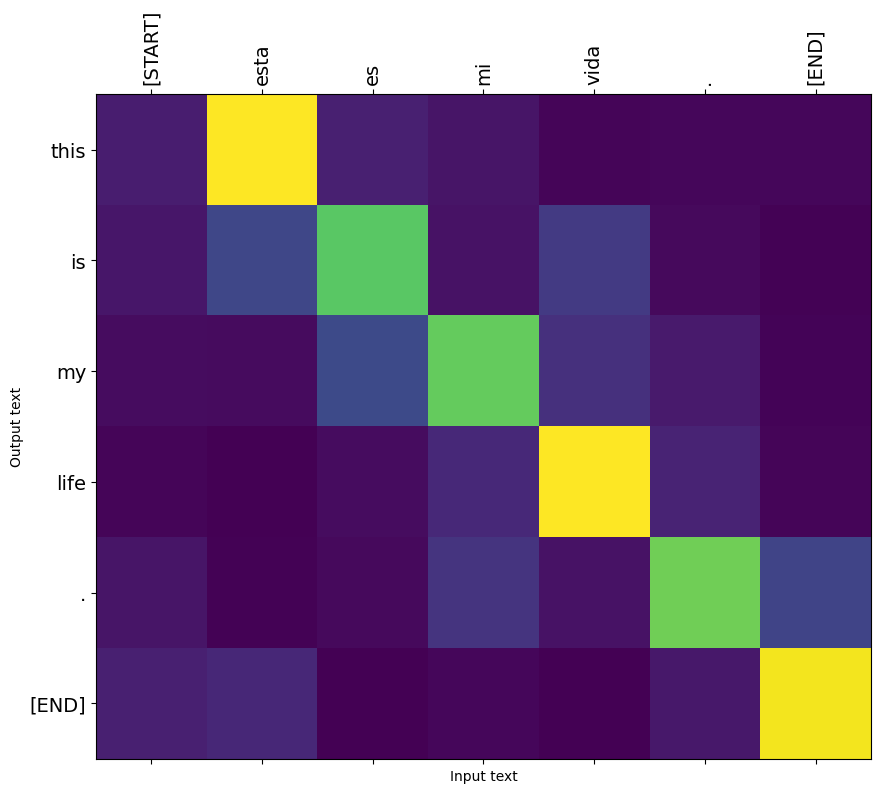

In [78]:
%%time
# Visualize the attention weights for the translation of the Spanish sentence "Esta es mi vida." "This is my life."
# This will show which input words the model attends to when generating each output word.
model.plot_attention('Esta es mi vida.')
plt.savefig("assets/attention_plot_esta_es_mi_vida.png")

/home/zkhechadoorian/Spanish_and_Portuguese_Translator/.venv/lib/python3.12/site-packages/keras/src/layers/layer.py:970: UserWarning: Layer 'cross_attention_2' (of type CrossAttention) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/home/zkhechadoorian/Spanish_and_Portuguese_Translator/.venv/lib/python3.12/site-packages/keras/src/layers/layer.py:970: UserWarning: Layer 'decoder_1' (of type Decoder) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/tmp/ipykernel_3306671/149752333.py:62: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + context_text, fontdict=fontdict, rotation=90)
/tm

CPU times: user 313 ms, sys: 4.04 ms, total: 317 ms
Wall time: 303 ms


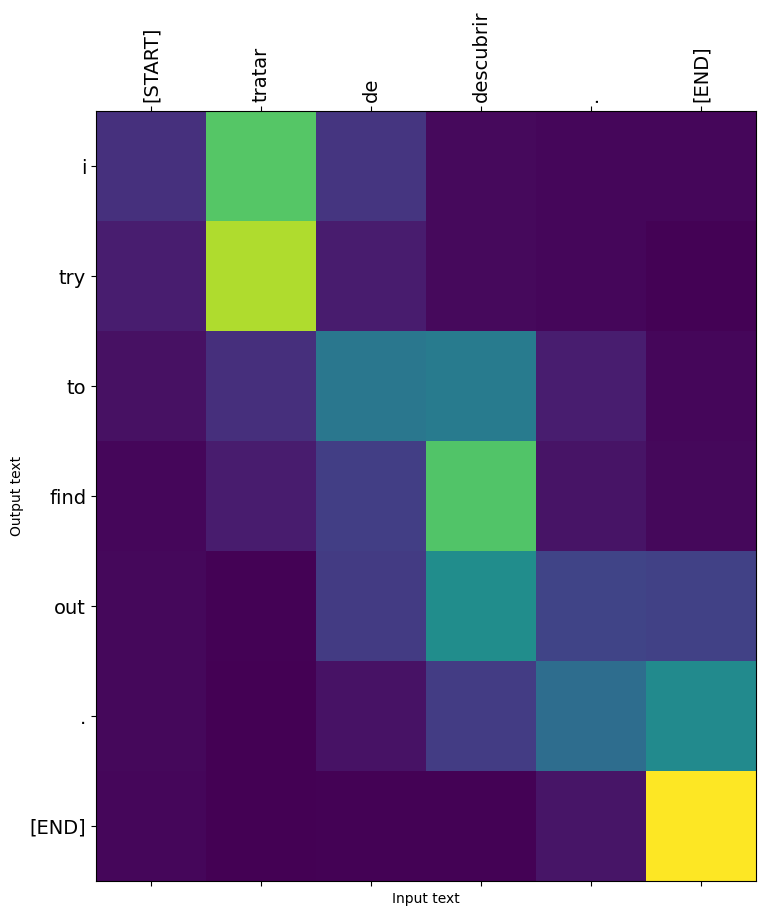

In [79]:
%%time
# Visualize the attention weights for the translation of the Spanish sentence "Tratar de descubrir." "Try to find out."
# This will show which input words the model attends to when generating each output word.
model.plot_attention('Tratar de descubrir.')

The short sentences often work well, but if the input is too long the model literally loses focus and stops providing reasonable predictions. There are two main reasons for this:

1. The model was trained with teacher-forcing feeding the correct token at each step, regardless of the model's predictions. The model could be made more robust if it were sometimes fed its own predictions. 🏫🤖
2. The model only has access to its previous output through the RNN state. If the RNN state looses track of where it was in the context sequence there's no way for the model to recover. [Transformers](transformer.ipynb) improve on this by letting the decoder look at what it has output so far. 🔄🧠✨

The raw data is sorted by length, so try translating the longest sequence:

In [80]:
# Get the longest Spanish sentence from the dataset
long_text = context_raw[-1]

# Import the textwrap module for formatting long strings
import textwrap

# Print the expected English translation, wrapped for readability
print('Expected output:\n', '\n'.join(textwrap.wrap(target_raw[-1])))

Expected output:
 If you want to sound like a native speaker, you must be willing to
practice saying the same sentence over and over in the same way that
banjo players practice the same phrase over and over until they can
play it correctly and at the desired tempo.


/home/zkhechadoorian/Spanish_and_Portuguese_Translator/.venv/lib/python3.12/site-packages/keras/src/layers/layer.py:970: UserWarning: Layer 'cross_attention_2' (of type CrossAttention) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/home/zkhechadoorian/Spanish_and_Portuguese_Translator/.venv/lib/python3.12/site-packages/keras/src/layers/layer.py:970: UserWarning: Layer 'decoder_1' (of type Decoder) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/tmp/ipykernel_3306671/149752333.py:62: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + context_text, fontdict=fontdict, rotation=90)
/tm

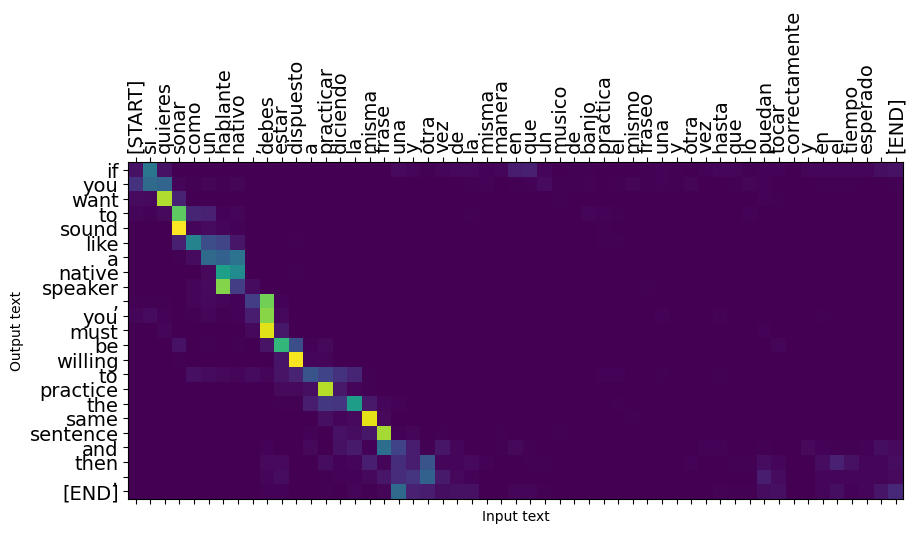

In [81]:
# Plot the attention weights for the translation of the longest Spanish sentence in the dataset.
# This will visualize which input words the model attends to when generating each output word.
model.plot_attention(long_text)
plt.savefig("assets/attention_plot_long_text.png")

The `translate` function works on batches, so if you have multiple texts to translate you can pass them all at once, which is much more efficient than translating them one at a time:

In [82]:
# List of Spanish input sentences to translate
inputs = [
    'Hace mucho frio aqui.', # "It's really cold here."
    'Esta es mi vida.',      # "This is my life."
    'Su cuarto es un desastre.' # "His room is a mess"
]

In [83]:
%%time
# Loop through each Spanish input sentence in the 'inputs' list
for t in inputs:
  # Translate the sentence using the trained model and print the result as a decoded string
  print(model.translate([t])[0].numpy().decode())

print()  # Print a blank line for separation

/home/zkhechadoorian/Spanish_and_Portuguese_Translator/.venv/lib/python3.12/site-packages/keras/src/layers/layer.py:970: UserWarning: Layer 'cross_attention_2' (of type CrossAttention) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/home/zkhechadoorian/Spanish_and_Portuguese_Translator/.venv/lib/python3.12/site-packages/keras/src/layers/layer.py:970: UserWarning: Layer 'decoder_1' (of type Decoder) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


its very cold here . 
this is my life . 
his room is a disaster . 

CPU times: user 801 ms, sys: 13.8 ms, total: 815 ms
Wall time: 780 ms


In [84]:
%%time
# Translate a batch of Spanish input sentences using the trained model
result = model.translate(inputs)

# Print the English translation for each input sentence
print(result[0].numpy().decode())
print(result[1].numpy().decode())
print(result[2].numpy().decode())
print()

its very cold here .  
this is my life .  
his room is a disaster . 

CPU times: user 309 ms, sys: 9.37 ms, total: 318 ms
Wall time: 298 ms


So overall this text generation function mostly gets the job done, but so you've only used it here in python with eager execution. Let's try to export it next:

### Save Model 💾✨

If you want to export this model you'll need to wrap the `translate` method in a `tf.function`. That implementation will get the job done:


In [85]:
class Export(tf.Module):
  def __init__(self, model):
    # Store the trained translation model
    self.model = model

  @tf.function(input_signature=[tf.TensorSpec(dtype=tf.string, shape=[None])])
  def translate(self, inputs):
    # Exported translation function: takes a batch of strings and returns translations
    return self.model.translate(inputs)

In [86]:
# Create an instance of the Export class, wrapping the trained translation model.
# This allows you to export the model with a tf.function for inference.
export = Export(model)

Run the `tf.function` once to compile it:

In [87]:
%%time
# Run the exported translation function on a batch of input sentences.
# This will compile the tf.function and measure execution time.
_ = export.translate(tf.constant(inputs))

<unknown>:12: SyntaxWarning: invalid escape sequence '\['
<unknown>:14: SyntaxWarning: invalid escape sequence '\['
W0000 00:00:1760032347.875466 3306671 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "101" frequency: 2593 num_cores: 16 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 1048576 l3_cache_size: 37486592 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


CPU times: user 13.5 s, sys: 840 ms, total: 14.4 s
Wall time: 14.3 s


In [88]:
%%time
# Translate a batch of Spanish input sentences using the exported model.
result = export.translate(tf.constant(inputs))

# Print the English translation for each input sentence in the batch.
print(result[0].numpy().decode())
print(result[1].numpy().decode())
print(result[2].numpy().decode())
print()

its very cold here .                                             
this is my life .                                             
his room is a disaster .                                            

CPU times: user 122 ms, sys: 15.6 ms, total: 138 ms
Wall time: 45.2 ms


Now that the function has been traced it can be exported using `saved_model.save`:

In [89]:
!export WRAPT_DISABLE_EXTENSIONS=true

In [90]:
%%time
import os
# Set the path where the exported translator model will be saved
TRANSLATOR_PATH = os.path.join("artifacts", "translator")

# Export the model using TensorFlow's SavedModel format
# - export: the Export wrapper containing the translation model
# - TRANSLATOR_PATH: directory to save the model
# - signatures: specify the default serving signature for inference
tf.saved_model.save(export, TRANSLATOR_PATH,
                    signatures={'serving_default': export.translate})

/home/zkhechadoorian/Spanish_and_Portuguese_Translator/.venv/lib/python3.12/site-packages/keras/src/layers/layer.py:970: UserWarning: Layer 'cross_attention_2' (of type CrossAttention) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/home/zkhechadoorian/Spanish_and_Portuguese_Translator/.venv/lib/python3.12/site-packages/keras/src/layers/layer.py:970: UserWarning: Layer 'decoder_1' (of type Decoder) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


INFO:tensorflow:Assets written to: artifacts/translator/assets


INFO:tensorflow:Assets written to: artifacts/translator/assets


CPU times: user 10.7 s, sys: 1.18 s, total: 11.9 s
Wall time: 12 s


In [91]:
%%time
# Load the exported SavedModel from the specified path
reloaded = tf.saved_model.load(TRANSLATOR_PATH)

# Run the translate function once to warm up the model (compiles the graph for faster inference)
_ = reloaded.translate(tf.constant(inputs)) #warmup

W0000 00:00:1760032368.044008 3306671 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "101" frequency: 2593 num_cores: 16 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 1048576 l3_cache_size: 37486592 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


CPU times: user 7.79 s, sys: 197 ms, total: 7.99 s
Wall time: 7.88 s


In [92]:
%%time
# Translate a batch of Spanish input sentences using the reloaded exported model.
result = reloaded.translate(tf.constant(inputs))

# Print the English translation for each input sentence in the batch.
print(result[0].numpy().decode())
print(result[1].numpy().decode())
print(result[2].numpy().decode())
print()

its very cold here .                                             
this is my life .                                             
his room is a disaster .                                            

CPU times: user 118 ms, sys: 23 ms, total: 141 ms
Wall time: 47.5 ms


#### [Optional] Use a dynamic loop

It's worth noting that this initial implementation is not optimal. It uses a python loop:

```
for _ in range(max_length):
  ...
  if tf.executing_eagerly() and tf.reduce_all(done):
    break
```

The python loop is relatively simple but when `tf.function` converts this to a graph, it **statically unrolls** that loop. Unrolling the loop has two disadvantages:

1. It makes `max_length` copies of the loop body. So the generated graphs take longer to build, save and load.
1. You have to choose a fixed value for the `max_length`.
1. You can't `break` from a statically unrolled loop. The `tf.function`
  version will run the full `max_length` iterations on every call.
  That's why the `break` only works with eager execution. This is
  still marginally faster than eager execution, but not as fast as it could be.


To fix these shortcomings, the `translate_dynamic` method, below, uses a tensorflow loop:

```
for t in tf.range(max_length):
  ...
  if tf.reduce_all(done):
      break
```

It looks like a python loop, but when you use a tensor as the input to a `for` loop (or the condition of a `while` loop) `tf.function` converts it to a dynamic loop using operations like `tf.while_loop`.

There's no need for a `max_length` here it's just in case the model gets stuck generating a loop like: `the united states of the united states of the united states...`.

On the down side, to accumulate tokens from this dynamic loop you can't just append them to a python `list`, you need to use a `tf.TensorArray`:

```
tokens = tf.TensorArray(tf.int64, size=1, dynamic_size=True)
...
for t in tf.range(max_length):
    ...
    tokens = tokens.write(t, next_token) # next_token shape is (batch, 1)
  ...
  tokens = tokens.stack()
  tokens = einops.rearrange(tokens, 't batch 1 -> batch t')
```

This version of the code can be quite a bit more efficient:

In [93]:
#@title
@Translator.add_method
def translate(self,
              texts,
              *,
              max_length=500,
              temperature=tf.constant(0.0)):

  # Create a shape checker utility to validate tensor shapes during debugging
  shape_checker = ShapeChecker()
  # Convert input texts to encoder input format
  context = self.encoder.convert_input(texts)
  # Get the batch size from the context tensor
  batch_size = tf.shape(context)[0]
  # Check the shape of the context tensor: (batch, sequence_length, units)
  shape_checker(context, 'batch s units')

  # Get initial decoder state, start tokens, and done mask for the batch
  next_token, done, state = self.decoder.get_initial_state(context)

  # Initialize a dynamic TensorArray to accumulate generated tokens
  tokens = tf.TensorArray(tf.int64, size=1, dynamic_size=True)

  # Loop to generate up to max_length tokens for each sequence in the batch
  for t in tf.range(max_length):
    # Generate the next token, update done mask and RNN state
    next_token, done, state = self.decoder.get_next_token(
        context, next_token, done, state, temperature)
    # Check the shape of the next token: (batch, 1)
    shape_checker(next_token, 'batch t1')

    # Write the generated token to the TensorArray
    tokens = tokens.write(t, next_token)

    # If all sequences are done, break out of the loop early
    if tf.reduce_all(done):
      break

  # Stack the generated tokens into a tensor: (time, batch, 1)
  tokens = tokens.stack()
  shape_checker(tokens, 't batch t1')
  # Rearrange the tensor to shape: (batch, time)
  tokens = einops.rearrange(tokens, 't batch 1 -> batch t')
  shape_checker(tokens, 'batch t')

  # Convert the token IDs back to text strings
  text = self.decoder.tokens_to_text(tokens)
  shape_checker(text, 'batch')

  # Return the generated text for each input sequence
  return text

With eager execution this implementation performs on par with the original:

In [94]:
%%time
# Translate a batch of Spanish input sentences using the trained model
result = model.translate(inputs)

# Print the English translation for each input sentence in the batch
print(result[0].numpy().decode())
print(result[1].numpy().decode())
print(result[2].numpy().decode())
print()

its very cold here .  
this is my life .  
his room is a disaster . 

CPU times: user 338 ms, sys: 3.4 ms, total: 341 ms
Wall time: 319 ms


/home/zkhechadoorian/Spanish_and_Portuguese_Translator/.venv/lib/python3.12/site-packages/keras/src/layers/layer.py:970: UserWarning: Layer 'cross_attention_2' (of type CrossAttention) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/home/zkhechadoorian/Spanish_and_Portuguese_Translator/.venv/lib/python3.12/site-packages/keras/src/layers/layer.py:970: UserWarning: Layer 'decoder_1' (of type Decoder) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


But when you wrap it in a `tf.function` you'll notice two differences.

In [95]:
class Export(tf.Module):
  def __init__(self, model):
    # Store the trained translation model
    self.model = model

  @tf.function(input_signature=[tf.TensorSpec(dtype=tf.string, shape=[None])])
  def translate(self, inputs):
    # Exported translation function: takes a batch of strings and returns translations
    return self.model.translate(inputs)

In [96]:
# Create an instance of the Export class, wrapping the trained translation model.
# This allows you to export the model with a tf.function for inference.
export = Export(model)

First, it's much quicker to trace, since it only creates one copy of the loop body:

In [97]:
%%time
# Run the exported translation function on the batch of input sentences.
# This will compile and execute the tf.function for inference timing.
_ = export.translate(inputs)

W0000 00:00:1760032373.320690 3306671 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "101" frequency: 2593 num_cores: 16 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 1048576 l3_cache_size: 37486592 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


CPU times: user 2.37 s, sys: 161 ms, total: 2.53 s
Wall time: 2.5 s


The `tf.function` is much faster than running with eager execution, and on small inputs it's often several times faster than the unrolled version, because it can break out of the loop.

In [98]:
%%time
# Translate the batch of Spanish input sentences using the exported model
result = export.translate(inputs)

# Print the English translation for each input sentence in the batch
print(result[0].numpy().decode())
print(result[1].numpy().decode())
print(result[2].numpy().decode())
print()

its very cold here .  
this is my life .  
his room is a disaster . 

CPU times: user 27.7 ms, sys: 16.8 ms, total: 44.5 ms
Wall time: 13.1 ms


So save this version as well:

In [99]:
%%time
# Set the path for saving the dynamically exported translator model
DYNAMIC_TRANSLATOR_PATH = os.path.join("artifacts", "dynamic_translator")

# Export the model using TensorFlow's SavedModel format
# - export: the Export wrapper containing the translation model
# - DYNAMIC_TRANSLATOR_PATH: directory to save the model
# - signatures: specify the default serving signature for inference
tf.saved_model.save(export, DYNAMIC_TRANSLATOR_PATH,
                    signatures={'serving_default': export.translate})

/home/zkhechadoorian/Spanish_and_Portuguese_Translator/.venv/lib/python3.12/site-packages/keras/src/layers/layer.py:970: UserWarning: Layer 'cross_attention_2' (of type CrossAttention) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/home/zkhechadoorian/Spanish_and_Portuguese_Translator/.venv/lib/python3.12/site-packages/keras/src/layers/layer.py:970: UserWarning: Layer 'decoder_1' (of type Decoder) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


INFO:tensorflow:Assets written to: artifacts/dynamic_translator/assets


INFO:tensorflow:Assets written to: artifacts/dynamic_translator/assets


CPU times: user 2.01 s, sys: 167 ms, total: 2.18 s
Wall time: 2.17 s


In [100]:
%%time
# Load the exported dynamic translator model from the specified path
reloaded = tf.saved_model.load(DYNAMIC_TRANSLATOR_PATH)

# Run the translate function once on the batch of input sentences to warm up the model (compiles the graph for faster inference)
_ = reloaded.translate(tf.constant(inputs)) #warmup

CPU times: user 1.16 s, sys: 54 ms, total: 1.21 s
Wall time: 1.18 s


W0000 00:00:1760032376.726911 3306671 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "101" frequency: 2593 num_cores: 16 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 1048576 l3_cache_size: 37486592 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


In [101]:
%%time
# Translate the batch of Spanish input sentences using the reloaded exported model.
result = reloaded.translate(tf.constant(inputs))

# Print the English translation for each input sentence in the batch.
print(result[0].numpy().decode())
print(result[1].numpy().decode())
print(result[2].numpy().decode())
print()

its very cold here .  
this is my life .  
his room is a disaster . 

CPU times: user 33.4 ms, sys: 8.7 ms, total: 42.1 ms
Wall time: 12.2 ms


## Next steps

* [Download a different dataset](http://www.manythings.org/anki/) to experiment with translations, for example, English to German, or English to French.
* Experiment with training on a larger dataset, or using more epochs.
* Try the [transformer tutorial](transformer.ipynb) which implements a similar translation task but uses transformer layers instead of RNNs. This version also uses a `text.BertTokenizer` to implement word-piece tokenization.
* Visit the [`tensorflow_addons.seq2seq` tutorial](https://www.tensorflow.org/addons/tutorials/networks_seq2seq_nmt), which demonstrates a higher-level functionality for implementing this sort of sequence-to-sequence model, such as `seq2seq.BeamSearchDecoder`.